# Libraries

In [1]:
import pandas as pd
import inflection
import missingno as msno
import seaborn as sns
import numpy as np
import re

import scipy.stats as stats
from scipy import stats as ss
from scipy.stats import chi2_contingency
from matplotlib import pyplot as plt
from IPython.display import Image
from utils import *

import ipywidgets as widgets
from ipywidgets import interact
import plotly.express as px

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, CDSView, IndexFilter
from bokeh.layouts import row, column
from scipy.stats import gaussian_kde
from bokeh.models import RangeSlider

from sklearn import preprocessing as pp
from imblearn import under_sampling as us
from imblearn import over_sampling as oversamp
from pandas_profiling import ProfileReport
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection as ms
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec
from sklearn.cluster import DBSCAN

import random
from sklearn import metrics as m
from sklearn.metrics import classification_report, cohen_kappa_score, roc_curve, brier_score_loss
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, recall_score, f1_score, roc_auc_score, precision_score, roc_curve
#from sklearn.metrics import plot_precision_recall_curve

from scikitplot import metrics as mt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn import svm
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
import category_encoders

from datetime import datetime, timedelta
import pickle

# Loading Data

In [2]:
pwd

'/Users/lucasquemelli/Documents/repos/credit_risk_assessment'

In [3]:
data = pd.read_csv("/Users/lucasquemelli/Documents/repos/credit_risk_assessment/credit_risk_dataset.csv")
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
data.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

# Duplication Analysis

Since this analysis should be at user level, would it be affordable to have repeated rows?
        
        * Ideally, we should have some column-key such as userid to identify any specific user. 

In [5]:
data.shape[0]

32581

In [6]:
data.drop_duplicates(inplace=True)

In [7]:
data.shape[0]

32416

# Helper Functions

In [8]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y).values
    n = confusion_matrix.sum()
    r,k = confusion_matrix.shape
   
    chi2 = chi2_contingency(confusion_matrix)[0]
    phi2 = chi2/n
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
   
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# 1. Data Description

In [9]:
df1 = data.copy()

- person_age: Age of the individual applying for the loan.

- person_income: Annual income of the individual.

- person_home_ownership: Type of home ownership of the individual.

        - rent: The individual is currently renting a property.
        - mortgage: The individual has a mortgage on the property they own.
        - own: The individual owns their home outright.
        - other: Other categories of home ownership that may be specific to the dataset.
        
- person_emp_length: Employment length of the individual in years.

- loan_intent: The intent behind the loan application.

- loan_grade: The grade assigned to the loan based on the creditworthiness of the borrower.

        - A: The borrower has a high creditworthiness, indicating low risk.
        - B: The borrower is relatively low-risk, but not as creditworthy as Grade A.
        - C: The borrower's creditworthiness is moderate.
        - D: The borrower is considered to have higher risk compared to previous grades.
        - E: The borrower's creditworthiness is lower, indicating a higher risk.
        - F: The borrower poses a significant credit risk.
        - G: The borrower's creditworthiness is the lowest, signifying the highest risk.
        
- loan_amnt: The loan amount requested by the individual.

- loan_int_rate: The interest rate associated with the loan.

- loan_status: Loan status, where 0 indicates non-default and 1 indicates default.

        - 0: Non-default - The borrower successfully repaid the loan as agreed, and there was no default.
        - 1: Default - The borrower failed to repay the loan according to the agreed-upon terms and defaulted on the loan.
        
- loan_percent_income: The percentage of income represented by the loan amount.

- cb_person_default_on_file: Historical default of the individual as per credit bureau records.

        - Y: The individual has a history of defaults on their credit file.
        - N: The individual does not have any history of defaults.
        
- cb_person_cred_hist_length: The length of credit history for the individual.

## 1.1. Data Dimensions

In [10]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 32416
Number of cols: 12


## 1.2. Data Types

In [11]:
df1.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

## 1.3. Na Check

In [12]:
df1.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [13]:
df1["person_emp_length"].min()

0.0

In [14]:
df1["loan_int_rate"].min()

5.42

In [15]:
df1["loan_int_rate"].max()

23.22

In [16]:
df1["person_emp_length"] = df1["person_emp_length"].fillna(-1.0)

df1["loan_int_rate"] = df1["loan_int_rate"].fillna(-1.0)

In [17]:
df1.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

## 1.4. Descriptive Statistics

In [18]:
num_attributes = df1.select_dtypes(include=['int32', 'int64', 'float32', 'float64'])
cat_attributes = df1.select_dtypes(include=['object', 'category'])

### 1.4.1. Numerical Attributes

In [19]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,person_age,20.000,144.000,124.000,27.747,26.000,6.354,2.580,18.560
1,person_income,4000.000,6000000.000,5996000.000,66091.641,55000.000,62014.624,32.959,2701.116
2,person_emp_length,-1.000,123.000,124.000,4.632,4.000,4.196,2.499,40.846
3,loan_amnt,500.000,35000.000,34500.000,9593.846,8000.000,6322.633,1.192,1.421
4,loan_int_rate,-1.000,23.220,24.220,9.870,10.620,4.688,-0.798,0.461
5,loan_status,0.000,1.000,1.000,0.219,0.000,0.413,1.361,-0.147
6,loan_percent_income,0.000,0.830,0.830,0.170,0.150,0.107,1.064,1.218
7,cb_person_cred_hist_length,2.000,30.000,28.000,5.811,4.000,4.059,1.659,3.706


- There is no person in the world with age of 144. We must treat outliers for person_age.
- person_emp_length equals to 123 seems inadequate. We must analyze with a distribution to idenfify outliers.
- It seems the majority of people have lower income, since we found a high standard deviation and positive skew.

#### Person Age

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


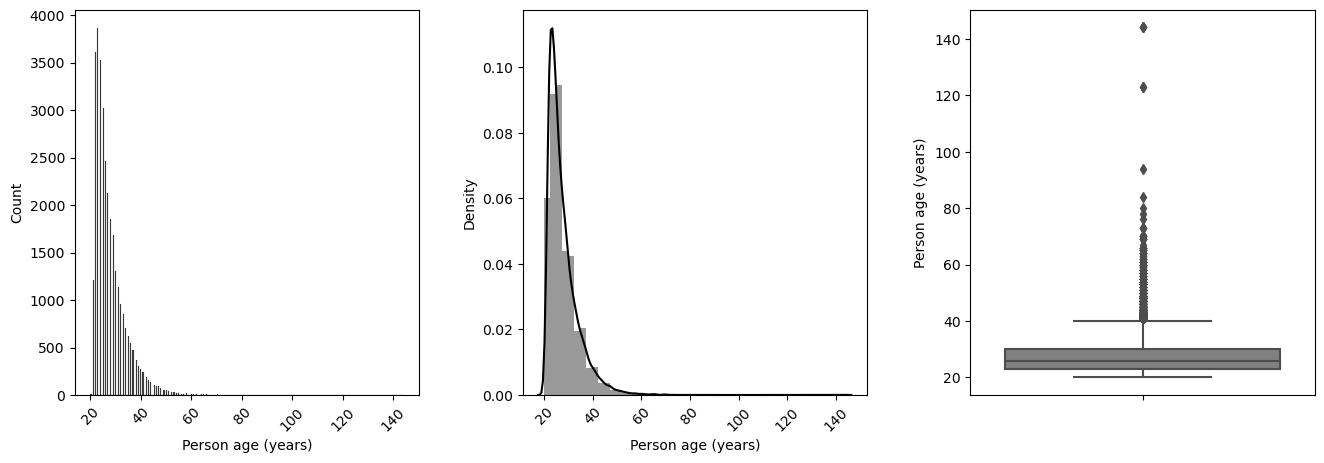

In [20]:
aux = num_attributes.copy()

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["person_age"], color="black")
plt.xlabel("Person age (years)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["person_age"], color="black")
plt.xlabel("Person age (years)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='person_age',data=aux, color="gray")
plt.ylabel("Person age (years)")

plt.subplots_adjust(wspace = 0.30);

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


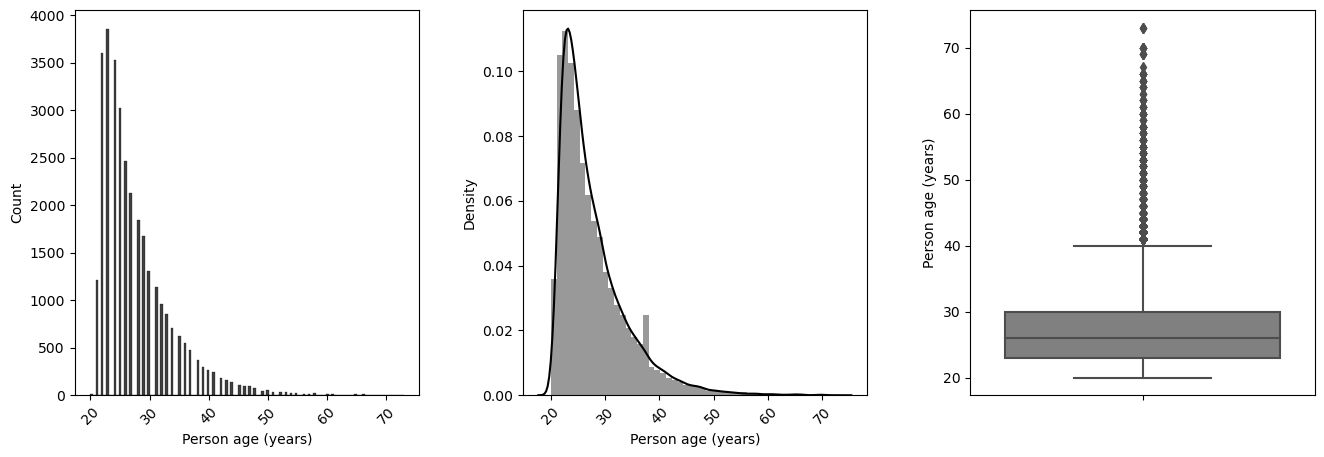

In [21]:
aux = num_attributes.copy()
aux = aux[aux["person_age"] <= 75]

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["person_age"], color="black")
plt.xlabel("Person age (years)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["person_age"], color="black")
plt.xlabel("Person age (years)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='person_age',data=aux, color="gray")
plt.ylabel("Person age (years)")

plt.subplots_adjust(wspace = 0.30);

In [22]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux["person_age"]).describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32406.00,27.72,6.17,20.00,23.00,26.00,30.00,73.00


- Since we have a high value for kurtosis, we may assume there are outliers for person age.
- Therefore, median is more representative than mean.
- Median is around 26 years.
- A value lower than 75 should be used as upper limit to remove outliers.

#### Person Income

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


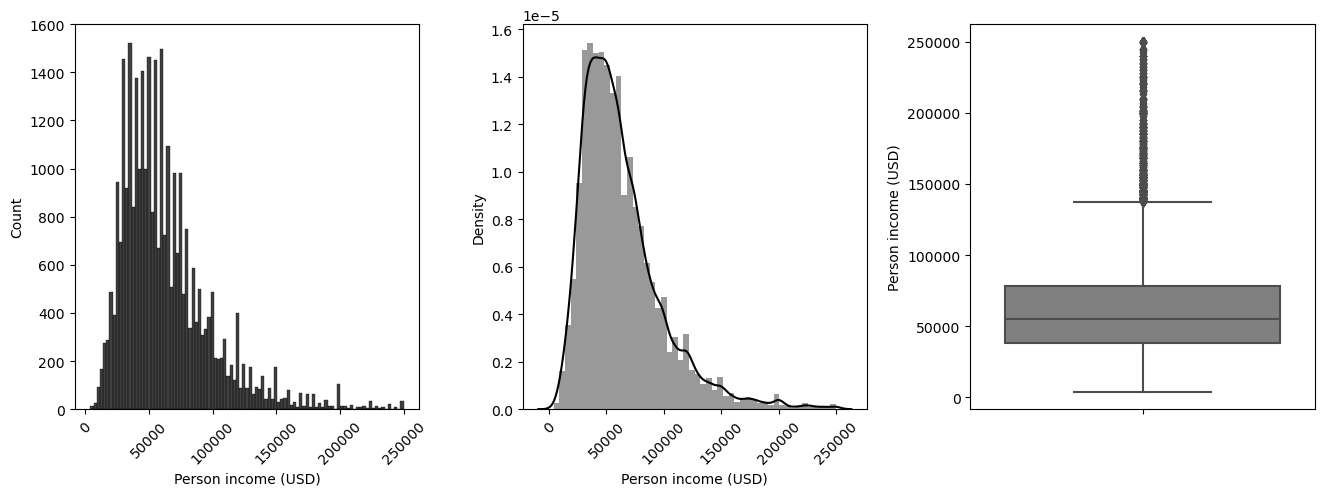

In [23]:
aux = num_attributes.copy()
aux = aux[aux["person_income"] <= 250000]

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["person_income"], color="black")
plt.xlabel("Person income (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["person_income"], color="black")
plt.xlabel("Person income (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='person_income',data=aux, color="gray")
plt.ylabel("Person income (USD)")

plt.subplots_adjust(wspace = 0.30);

In [24]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux["person_income"]).describe().T

,count,mean,std,min,25%,50%,75%,max
person_income,32184.00,63241.44,35600.17,4000.00,38400.00,55000.00,78000.00,250000.00


- Since we have a high value for kurtosis, we may assume there are outliers for person income.
- Therefore, median is more representative than mean.
- Median is around 55000 USD.
- A value lower than 250000 USD should be used as upper limit to remove outliers.

#### Person Employment Length

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


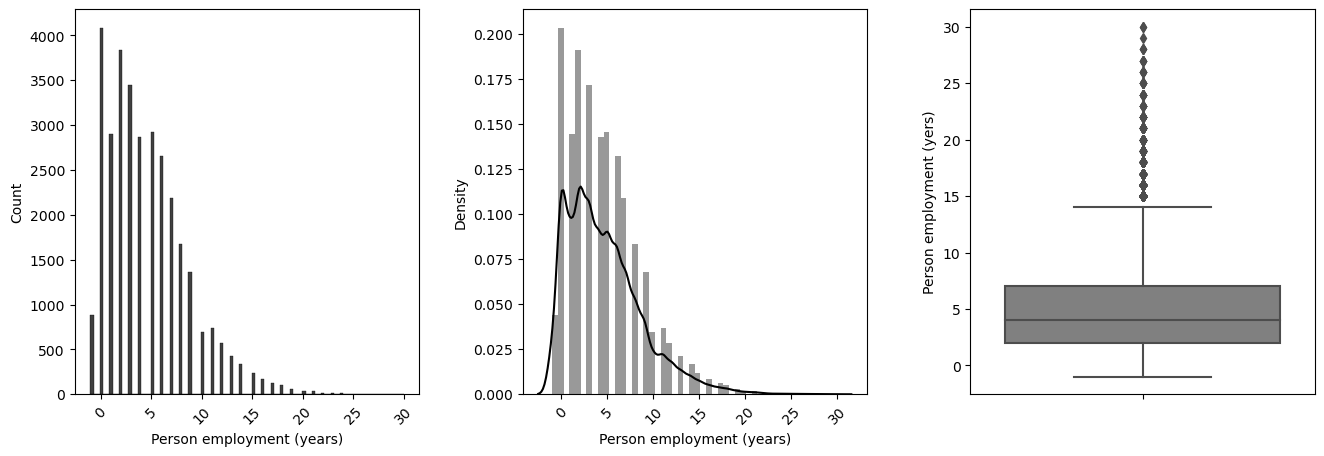

In [25]:
aux = num_attributes.copy()
aux = aux[aux["person_emp_length"] <= 30]

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["person_emp_length"], color="black")
plt.xlabel("Person employment (years)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["person_emp_length"], color="black")
plt.xlabel("Person employment (years)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='person_emp_length',data=aux, color="gray")
plt.ylabel("Person employment (yers)")

plt.subplots_adjust(wspace = 0.30);

In [26]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux["person_emp_length"]).describe().T

,count,mean,std,min,25%,50%,75%,max
person_emp_length,32407.00,4.62,4.07,-1.00,2.00,4.00,7.00,30.00


- Since we have a high value for kurtosis, we may assume there are outliers for person employment.
- Therefore, median is more representative than mean.
- Median is around 4 USD.
- A value lower than 30 years should be used as upper limit to remove outliers.

#### Loan Amount

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


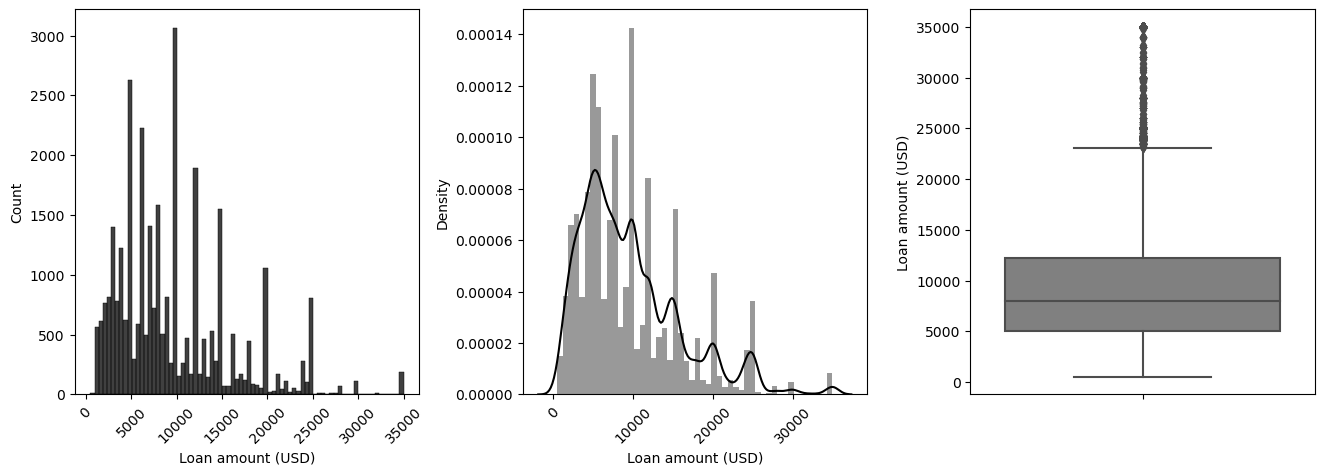

In [27]:
aux = num_attributes.copy()
# aux = aux[aux["loan_amnt"] <= 30]

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["loan_amnt"], color="black")
plt.xlabel("Loan amount (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["loan_amnt"], color="black")
plt.xlabel("Loan amount (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='loan_amnt',data=aux, color="gray")
plt.ylabel("Loan amount (USD)")

plt.subplots_adjust(wspace = 0.30);

In [28]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux["loan_amnt"]).describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,32416.00,9593.85,6322.73,500.00,5000.00,8000.00,12250.00,35000.00


- Median is around 8000 USD.
- Mean is around 9500 USD.

#### Loan Interest Rate

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


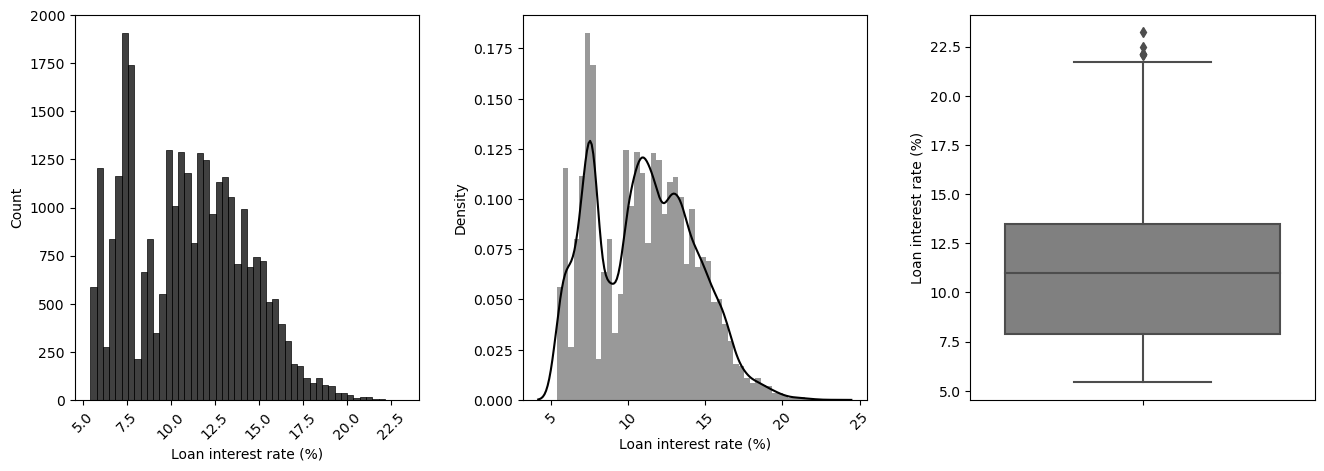

In [29]:
aux = num_attributes.copy()
aux = aux[aux["loan_int_rate"] >= 0]

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["loan_int_rate"], color="black")
plt.xlabel("Loan interest rate (%)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["loan_int_rate"], color="black")
plt.xlabel("Loan interest rate (%)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='loan_int_rate',data=aux, color="gray")
plt.ylabel("Loan interest rate (%)")

plt.subplots_adjust(wspace = 0.30);

In [30]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux[aux["loan_int_rate"] > 0]["loan_int_rate"]).describe().T

,count,mean,std,min,25%,50%,75%,max
loan_int_rate,29321.00,11.02,3.24,5.42,7.90,10.99,13.47,23.22


- Median: 10.99 %.
- Mean: 11.02 %.

#### Loan Percentage Income

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


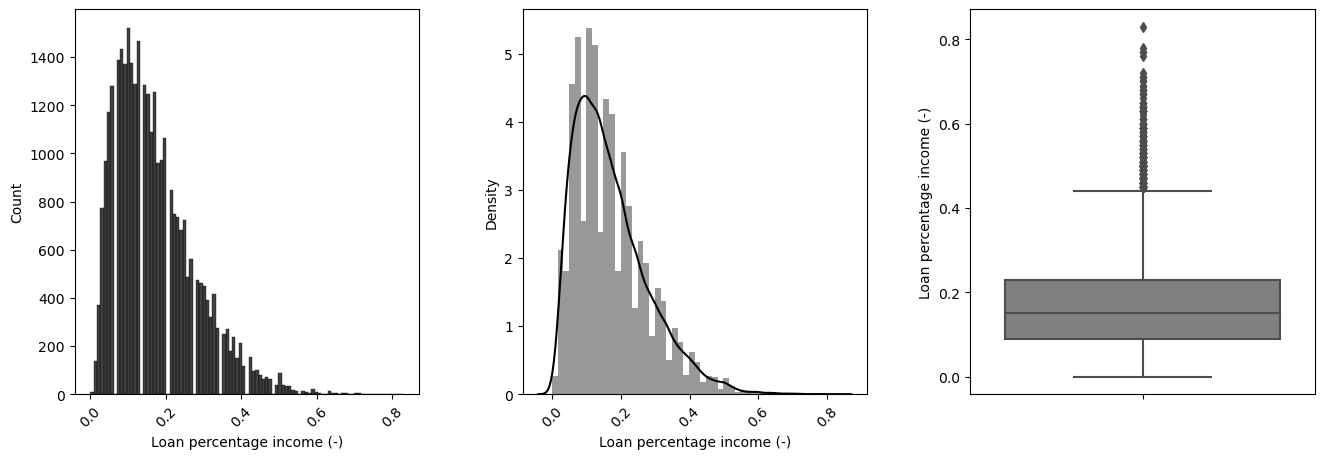

In [31]:
aux = num_attributes.copy()
# aux = aux[aux["loan_percent_income"] >= 0]

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["loan_percent_income"], color="black")
plt.xlabel("Loan percentage income (-)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["loan_percent_income"], color="black")
plt.xlabel("Loan percentage income (-)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='loan_percent_income',data=aux, color="gray")
plt.ylabel("Loan percentage income (-)")

plt.subplots_adjust(wspace = 0.30);

In [32]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux["loan_percent_income"]).describe().T

,count,mean,std,min,25%,50%,75%,max
loan_percent_income,32416.00,0.17,0.11,0.00,0.09,0.15,0.23,0.83


- Median: 0.15.
- Mean: 0.17.

#### Credit History Lenght

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


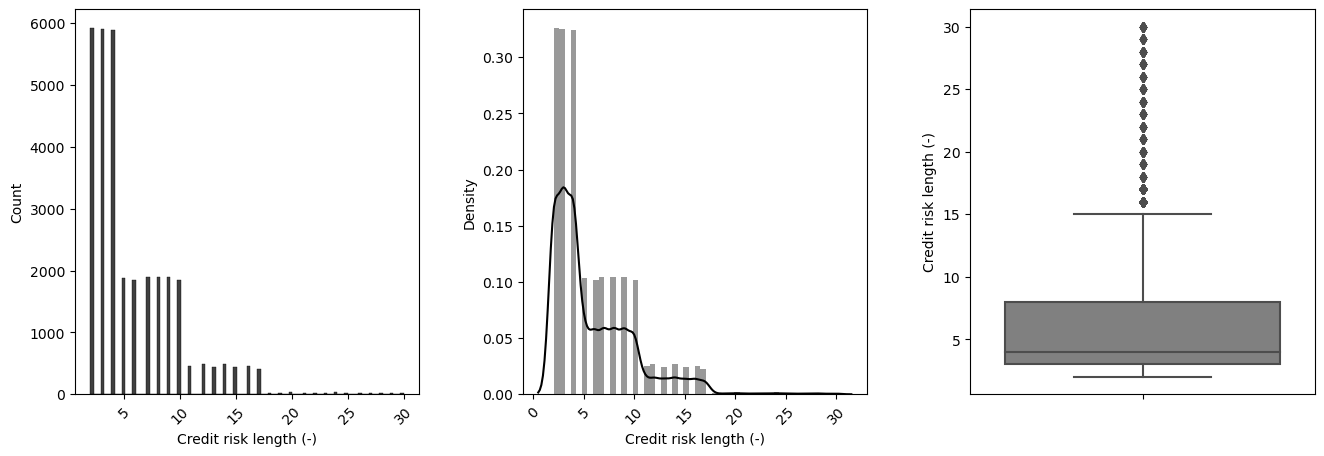

In [33]:
aux = num_attributes.copy()
# aux = aux[aux["cb_person_cred_hist_length"] >= 0]

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["cb_person_cred_hist_length"], color="black")
plt.xlabel("Credit risk length (-)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["cb_person_cred_hist_length"], color="black")
plt.xlabel("Credit risk length (-)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='cb_person_cred_hist_length',data=aux, color="gray")
plt.ylabel("Credit risk length (-)")

plt.subplots_adjust(wspace = 0.30);

In [34]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux["cb_person_cred_hist_length"]).describe().T

,count,mean,std,min,25%,50%,75%,max
cb_person_cred_hist_length,32416.00,5.81,4.06,2.00,3.00,4.00,8.00,30.00


- Median: 4.
- Mean: 5.81.

### 1.4.2. Correlation Matrix

We use it in order to evaluate variables which are highly correlated. The objective is to exclude one of them.

#### Pearson Correlation Coefficient

Pearson's correlation coefficient is used for linear correlation between variables.

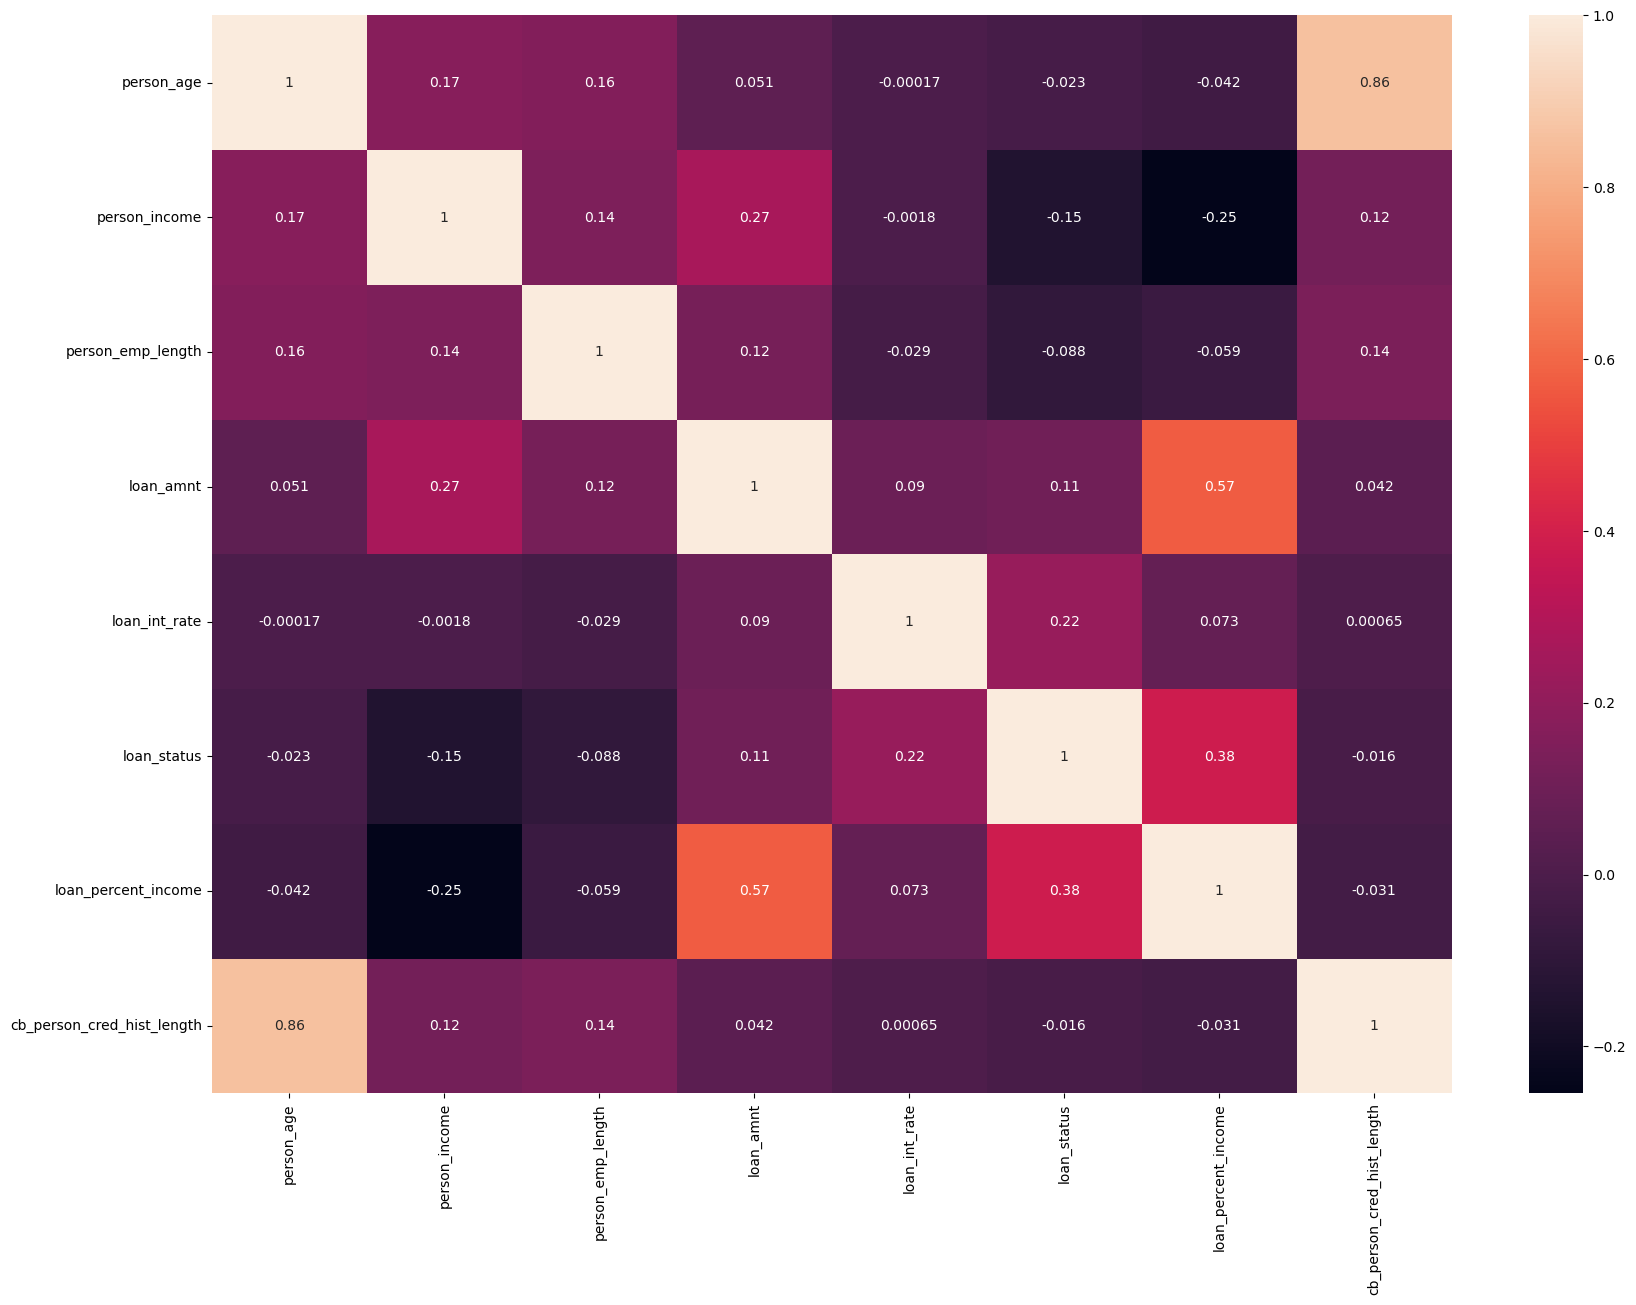

In [35]:
plt.figure(figsize = (20,14))

sns.heatmap(num_attributes.corr(method="pearson"), annot=True);

- cd_person_cred_hist_length and person_age.
- loan_percent_income and loan_amt.

#### Spearman Correlation Coefficient

Spearman's correlation coefficient is used to measure the monotonic correlation between variables. It is appropriate to use Spearman's correlation coefficient for nonlinear relationships.

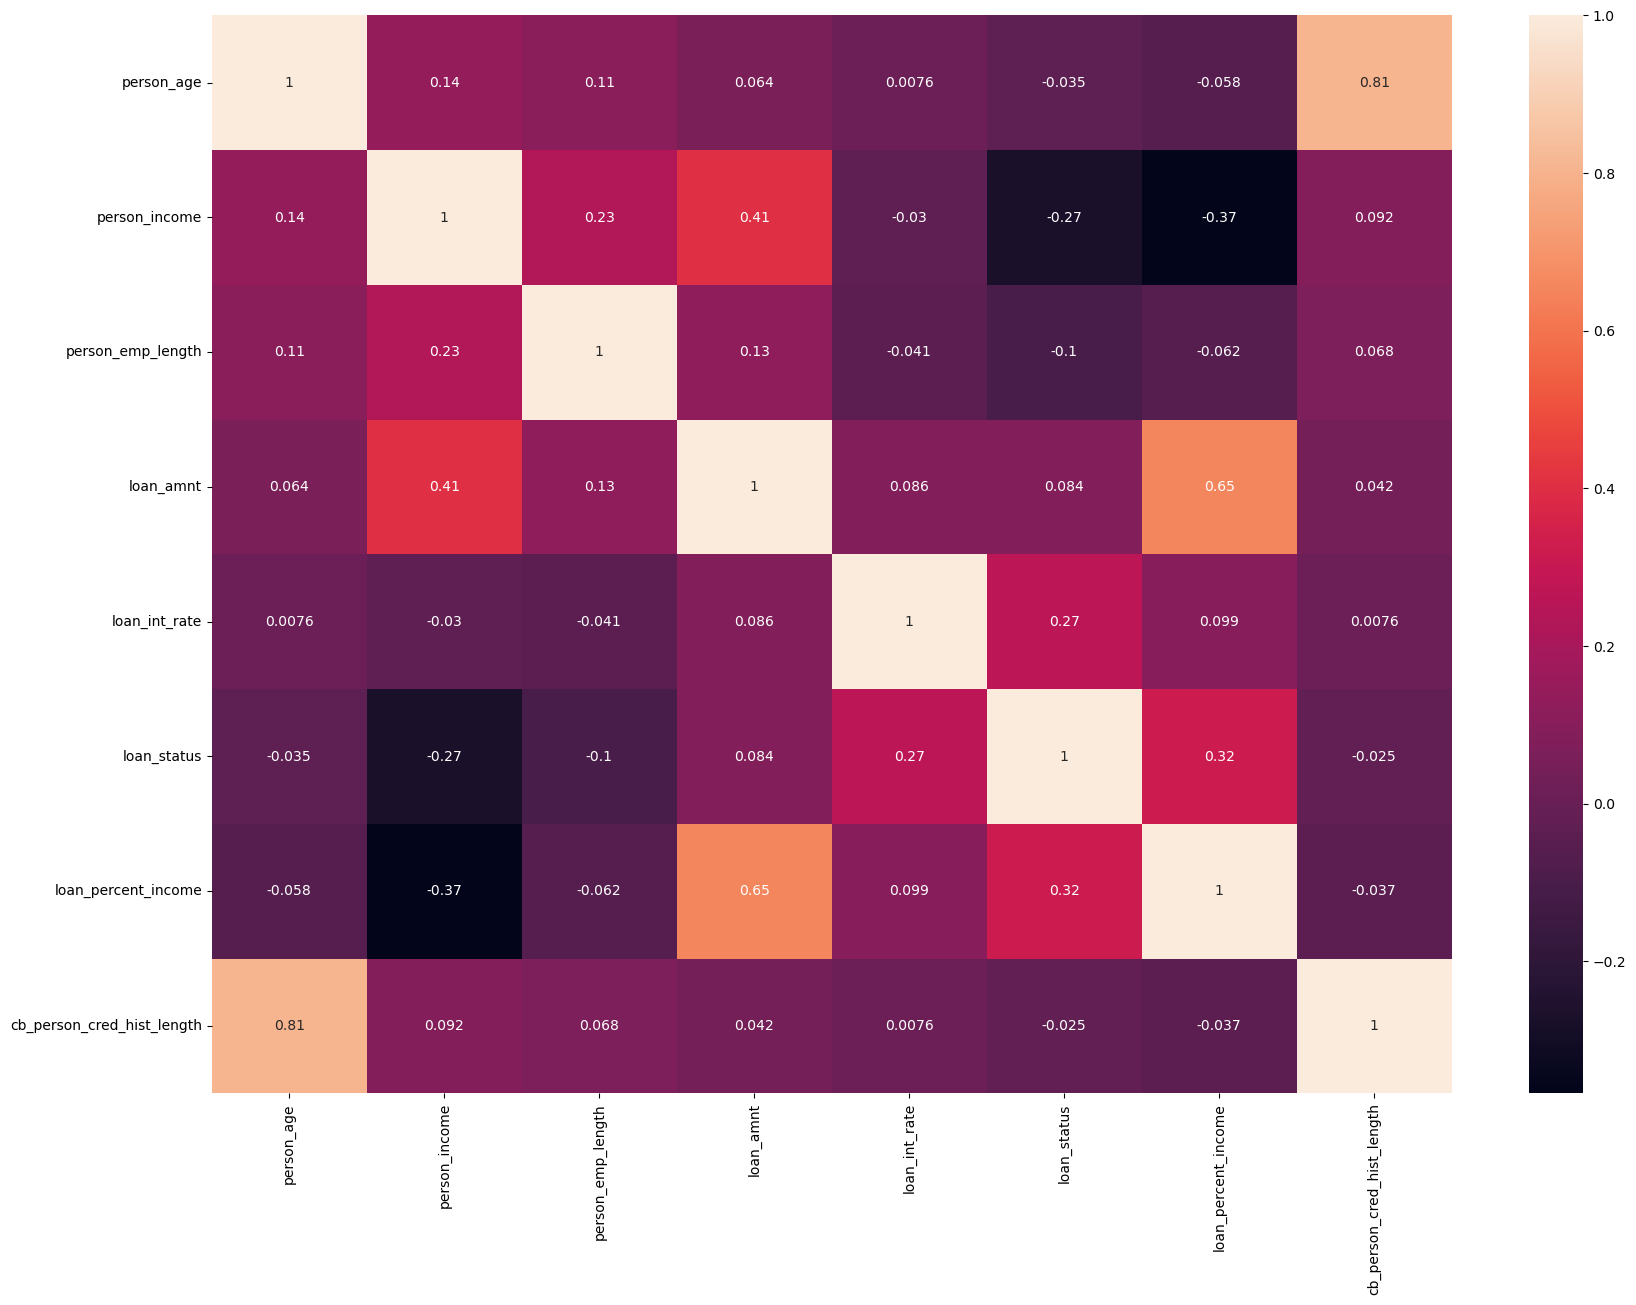

In [36]:
plt.figure(figsize = (20,14))

sns.heatmap(num_attributes.corr(method="spearman"), annot=True);

- cb_person_cred_hist_length and person_age.
- loan_percent_income and loan_amt.

#### Kendall Correlation Coefficient

Kendall's correlation coefficient, also known as Kendall's tau, is used to measure the strength and direction of the ordinal association between variables. It is appropriate to be used for ordinal and classified data, as well as for non-linear relationships between variables.

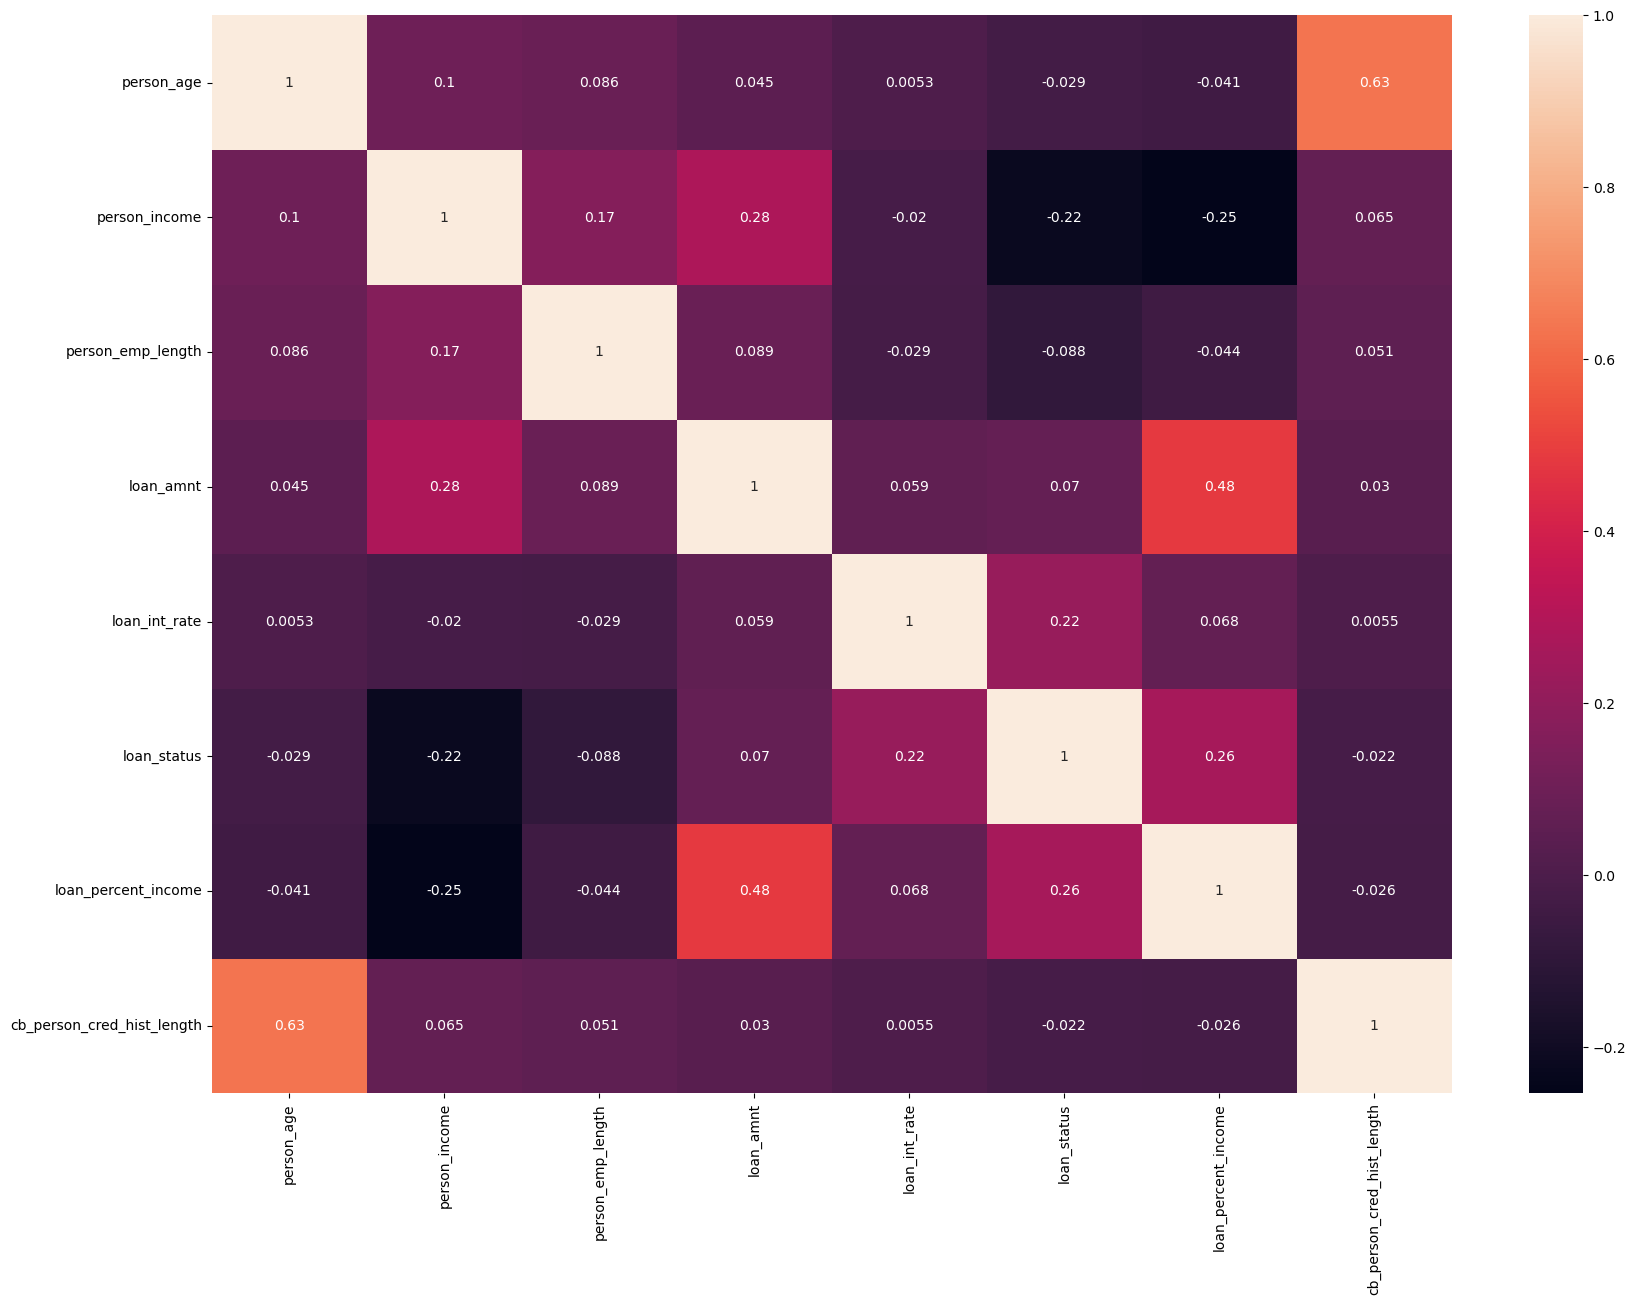

In [37]:
plt.figure(figsize = (20,14))

sns.heatmap(num_attributes.corr(method="kendall"), annot=True);

- cb_person_cred_hist_length and person_age.

### 1.4.3. Categorical Attributes

In [38]:
cat_attributes.apply(lambda x: x.unique().shape[0])

person_home_ownership        4
loan_intent                  6
loan_grade                   7
cb_person_default_on_file    2
dtype: int64

In [39]:
cat_attributes["person_home_ownership"].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [40]:
cat_attributes["loan_intent"].unique()

array(['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT',
       'DEBTCONSOLIDATION'], dtype=object)

In [41]:
cat_attributes["loan_grade"].unique()

array(['D', 'B', 'C', 'A', 'E', 'F', 'G'], dtype=object)

In [42]:
cat_attributes["cb_person_default_on_file"].unique()

array(['Y', 'N'], dtype=object)

In [43]:
cat_attributes.describe().T

,count,unique,top,freq
person_home_ownership,32416,4,RENT,16378
loan_intent,32416,6,EDUCATION,6411
loan_grade,32416,7,A,10703
cb_person_default_on_file,32416,2,N,26686


### 1.4.4. Correlation Matrix

In [44]:
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range( len (cat_attributes_list)):
    corr_list = []
    for j in range(len( cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramers_v(cat_attributes[ref], cat_attributes[feat])
        
        # append a list
        corr_list.append(corr)
    
    # append a correlation list for each ref attribute
    corr_dict[ref] = corr_list

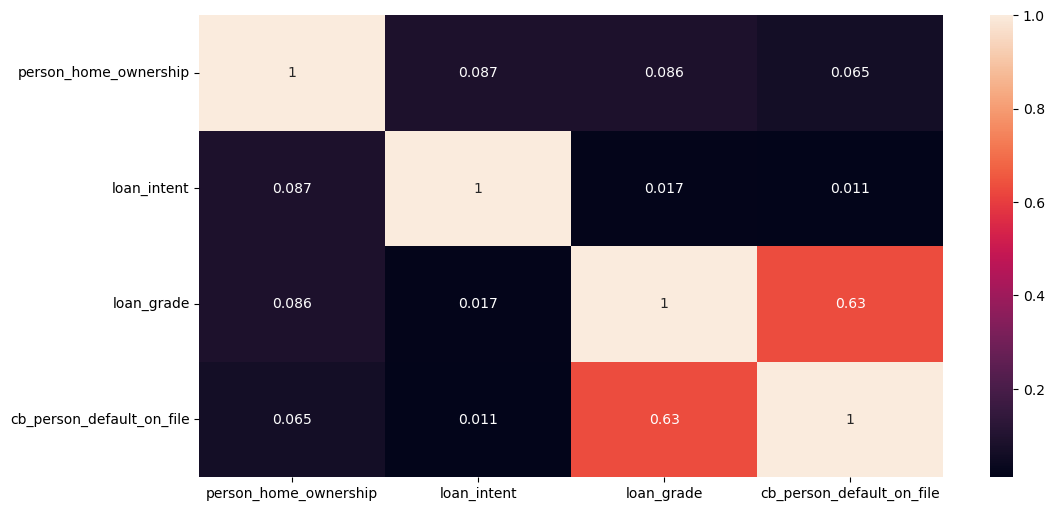

In [45]:
plt.figure(figsize =(12,6))

d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

- cb_person_default_on_file and loan_grade.

# 2. Feature Engineering

In [46]:
df2 = df1.copy()

In [47]:
df2.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.00,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.00,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.00,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.00,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.00,MEDICAL,C,35000,14.27,1,0.55,Y,4


1. Age Buckets:

        Classes for age ranges, like 'young,' 'middle-aged,' and 'senior.' This might help capture potential non-linear relationships between age and credit risk.

2. Income Bands:

        Income bands to group individuals with similar income levels. This can help the model identify patterns among different income groups.

3. Employment Length Categories:

        Convert employment length into categories like 'short-term,' 'medium-term,' and 'long-term.' This could help capture potential differences in credit risk based on how long someone has been employed.

4. Interest Rate Categories:

        Convert the interest rates into categories like 'low,' 'medium,' and 'high.' This might help capture the impact of interest rates on credit risk.

5. Combine Home Ownership Types:

        If there are specific categories within 'other,' we might consider combining them into a broader category or grouping them based on similar risk characteristics.

6. Create Dummy Variables:

        Convert categorical variables like 'loan_intent' and 'loan_grade' into dummy variables so that they can be used in a machine learning model.

7. Credit History Length Bands:

        Similar to income and age, we can create bands for credit history length.

8. Interaction Terms:

        Interaction terms between variables: the combination of 'loan_amount' and 'interest_rate' might provide additional insights.

10. income_per_loan: 

        Amount of income per number of loans. If the number of loans are higher, it is possible that the income is higher too.

In [48]:
# 1. Create Age Buckets
df2['age_buckets'] = pd.cut(df2['person_age'], bins=[18, 30, 45, 60, 100], labels=['young', 'middle-aged', 'senior', 'elderly'])

# 2. Income Bands
df2['income_band'] = pd.cut(df2['person_income'], bins=[0, 30000, 60000, 90000, 120000, float('inf')], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

# 3. Employment Length Categories
df2['employment_length_categories'] = pd.cut(df2['person_emp_length'], bins=[0, 2, 5, 10, float('inf')], labels=['short-term', 'medium-term', 'long-term', 'very-long-term'])

# 4. Interest Rate Categories
df2['interest_rate_categories'] = pd.cut(df2['loan_int_rate'], bins=[0, 10, 15, 20, float('inf')], labels=['low', 'medium', 'high', 'very_high'])

# 5. Combine Home Ownership Types
df2['person_home_ownership'] = df2['person_home_ownership'].replace({'other': 'miscellaneous'})

# 6. Create Dummy Variables
df2 = pd.get_dummies(df2, columns=['loan_intent', 'loan_grade'])

# 7. Credit History Length Bands
df2['cred_hist_length_band'] = pd.cut(df2['cb_person_cred_hist_length'], bins=[0, 2, 5, 10, 20, float('inf')], labels=['very_short', 'short', 'medium', 'long', 'very_long'])

# 8. Interaction Terms
df2['loan_amount_interest_interaction'] = df2['loan_amnt'] * df2['loan_int_rate']

# 10. Income per number of loans
df2['income_per_loan'] = (df2['person_income']/df2['cb_person_cred_hist_length']).replace([np.inf, -np.inf], 0).fillna(0)

In [49]:
# target
df2.rename(columns={"loan_status": "target"}, inplace=True)

Finally, let's create an userid to represent each row. Thus, we may understand that each row is represented by an user.

In [50]:
import uuid

# df2 is our DataFrame with each row representing a user
df2['user_id'] = [str(uuid.uuid4()) for _ in range(len(df2))]

# 3. Exploratory Data Analysis (EDA)

This section is designed to gain business knowledge for decision making. It is a section for analytical data exploration and for hypothesys tests.

In [52]:
df3 = df2.copy()

In [59]:
num_attributes = df3.select_dtypes(include=['int32', 'int64', 'float32', 'float64'])
cat_attributes = df3.select_dtypes(include=['object', 'category'])

## 3.1. Categorical Attributes

In [60]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

person_home_ownership               4
cb_person_default_on_file           2
age_buckets                         5
income_band                         5
employment_length_categories        5
interest_rate_categories            5
cred_hist_length_band               5
user_id                         32416
dtype: int64

### Person home ownership

In [54]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "person_home_ownership"]].groupby("person_home_ownership").nunique().\
                                                 reset_index().sort_values("person_home_ownership", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# Number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "person_home_ownership"]].groupby("person_home_ownership").\
                                    nunique().reset_index().sort_values("person_home_ownership", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

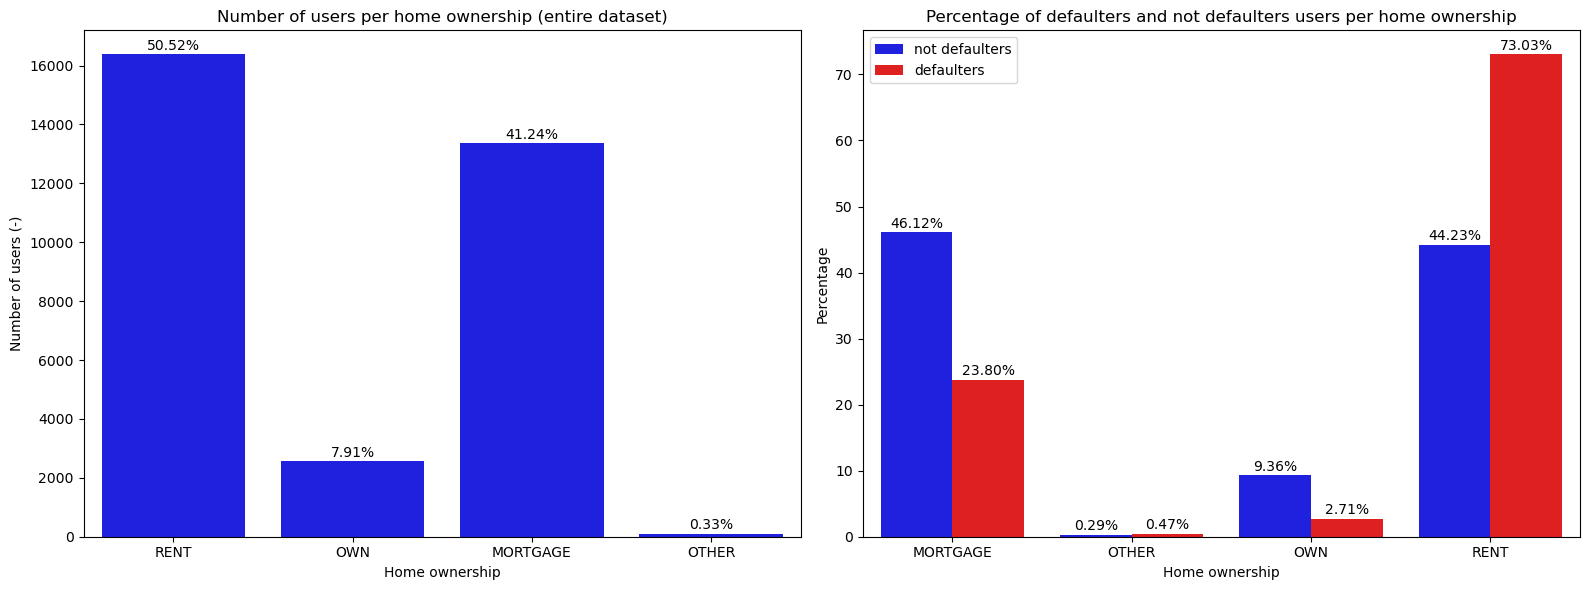

In [56]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'person_home_ownership', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per home ownership (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Home ownership", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
#ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="person_home_ownership", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per home ownership", fontsize=12)
ax1 = plt.xlabel("Home ownership", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)

# Adjustments
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

- Rent was more prone to have defaulters.

### History of default 

In [61]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "cb_person_default_on_file"]].groupby("cb_person_default_on_file").nunique().\
                                                 reset_index().sort_values("cb_person_default_on_file", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# Number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "cb_person_default_on_file"]].groupby("cb_person_default_on_file").\
                                    nunique().reset_index().sort_values("cb_person_default_on_file", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

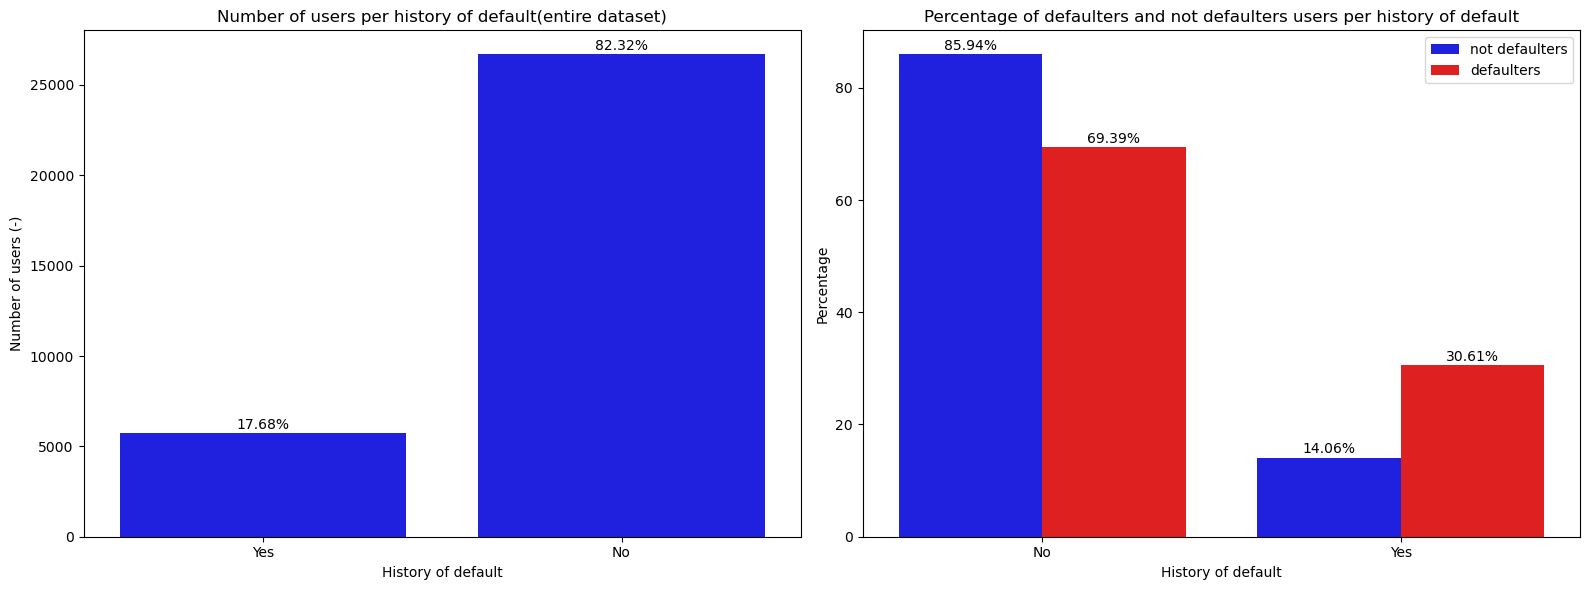

In [65]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'cb_person_default_on_file', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per history of default(entire dataset)", fontsize=12)
ax1 = plt.xlabel("History of default", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
ax1 = plt.xticks(np.arange(2), ["Yes", "No"])
#ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="cb_person_default_on_file", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per history of default", fontsize=12)
ax1 = plt.xlabel("History of default", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)
ax1 = plt.xticks(np.arange(2), ["No", "Yes"])

# Adjustments
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

- While we have more people as a non-defaulter, people defaulter were more prone to be a defaulter (as expected).

### Age buckets

In [66]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "age_buckets"]].groupby("age_buckets").nunique().\
                                                 reset_index().sort_values("age_buckets", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# Number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "age_buckets"]].groupby("age_buckets").\
                                    nunique().reset_index().sort_values("age_buckets", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

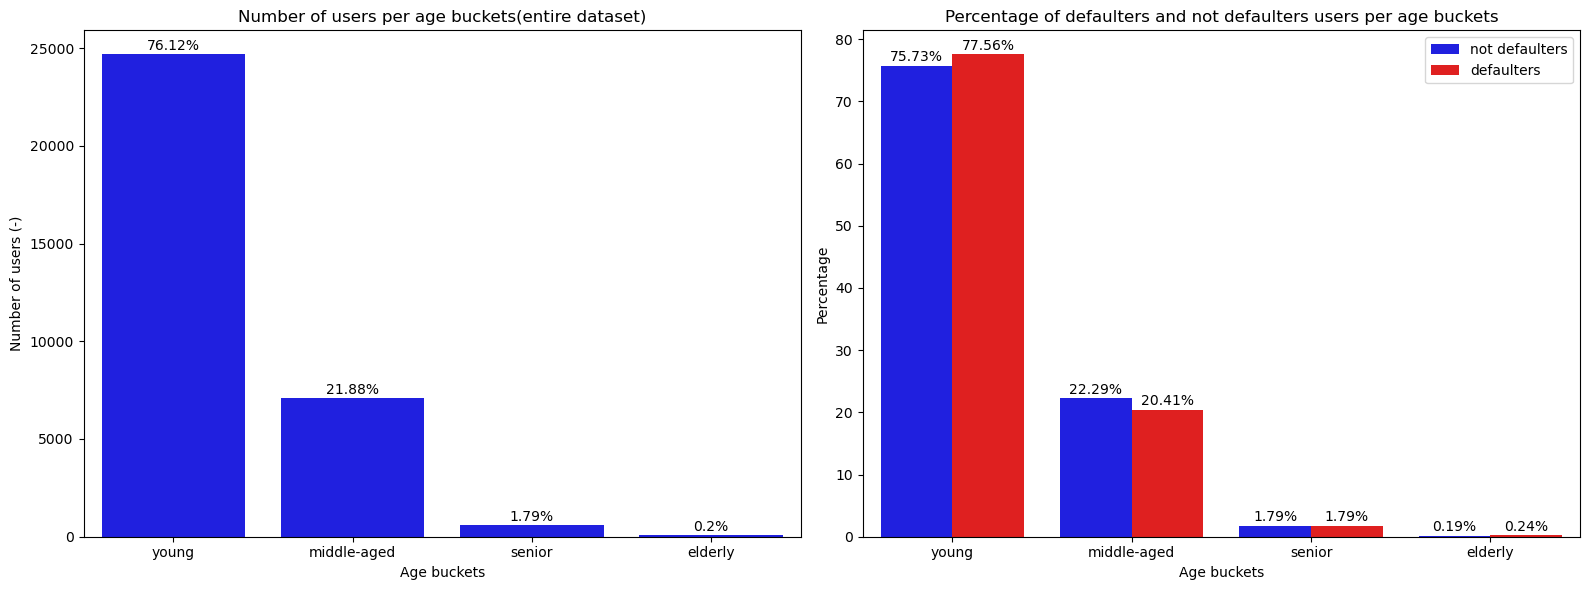

In [68]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'age_buckets', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per age buckets(entire dataset)", fontsize=12)
ax1 = plt.xlabel("Age buckets", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
#ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="age_buckets", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per age buckets", fontsize=12)
ax1 = plt.xlabel("Age buckets", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)

# Adjustments
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

- Young people are the majority of the entire dataset and also were more prone to be a defaulter.

### Income band

In [69]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "income_band"]].groupby("income_band").nunique().\
                                                 reset_index().sort_values("income_band", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# Number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "income_band"]].groupby("income_band").\
                                    nunique().reset_index().sort_values("income_band", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

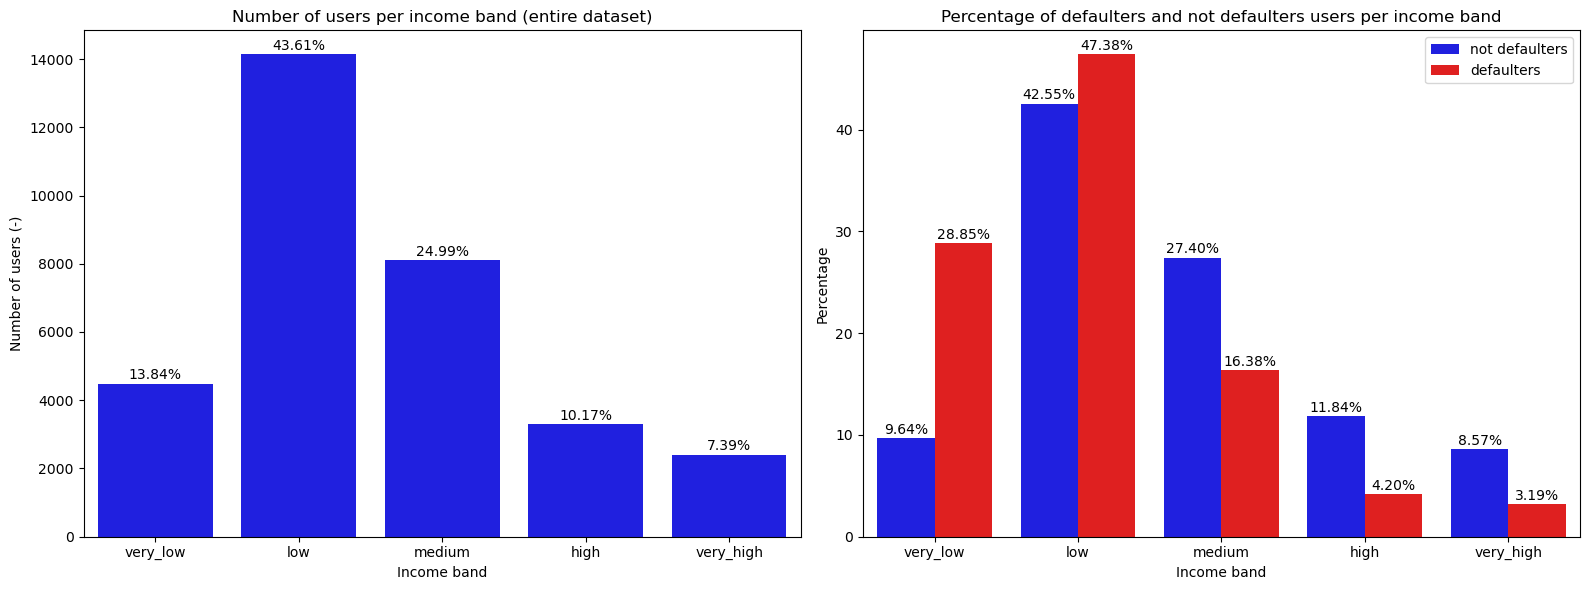

In [70]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'income_band', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per income band (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Income band", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
#ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="income_band", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per income band", fontsize=12)
ax1 = plt.xlabel("Income band", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)

# Adjustments
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

- Very low and low income band represented the customers which were more prone to be a defaulter.

### Employment legth categories

In [71]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "employment_length_categories"]].groupby("employment_length_categories").nunique().\
                                                 reset_index().sort_values("employment_length_categories", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# Number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "employment_length_categories"]].groupby("employment_length_categories").\
                                    nunique().reset_index().sort_values("employment_length_categories", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

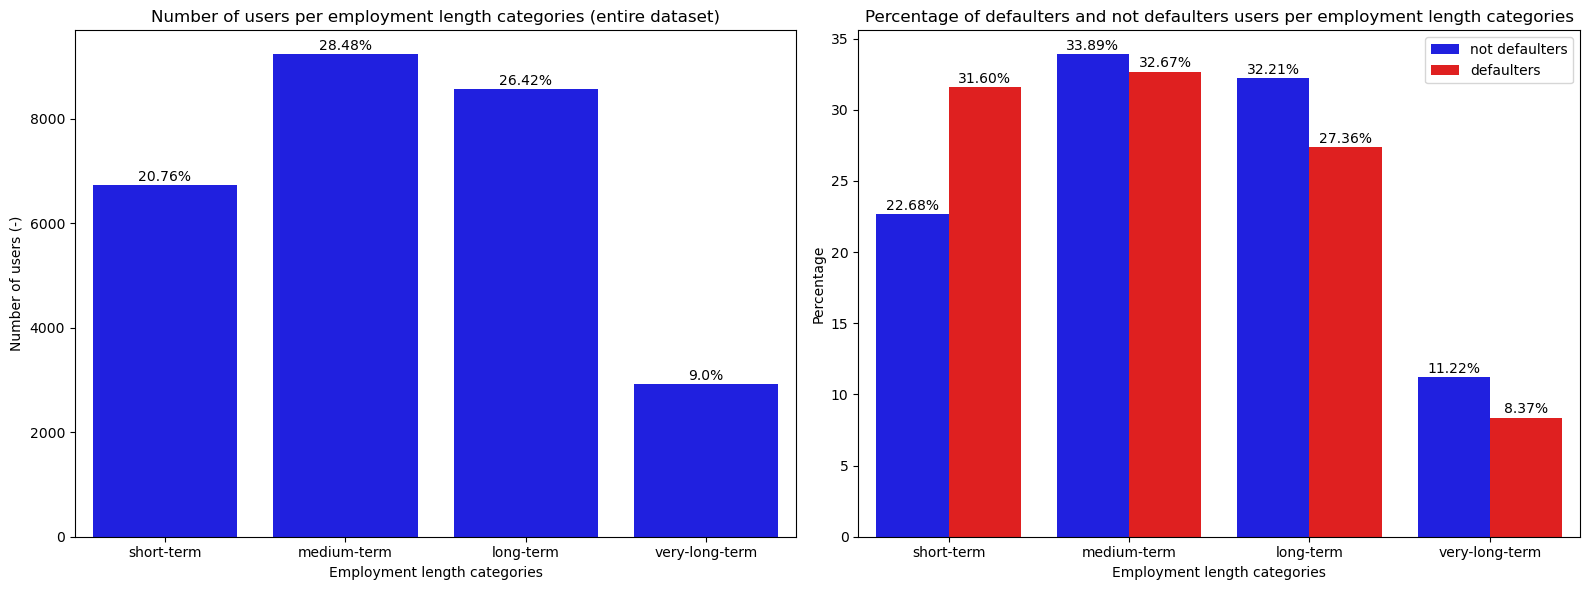

In [72]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'employment_length_categories', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per employment length categories (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Employment length categories", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
#ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="employment_length_categories", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per employment length categories", fontsize=12)
ax1 = plt.xlabel("Employment length categories", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)

# Adjustments
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

- People with short-term employment length were more prone to be a defaulter.

### Interest rate categories

In [73]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "interest_rate_categories"]].groupby("interest_rate_categories").nunique().\
                                                 reset_index().sort_values("interest_rate_categories", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# Number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "interest_rate_categories"]].groupby("interest_rate_categories").\
                                    nunique().reset_index().sort_values("interest_rate_categories", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

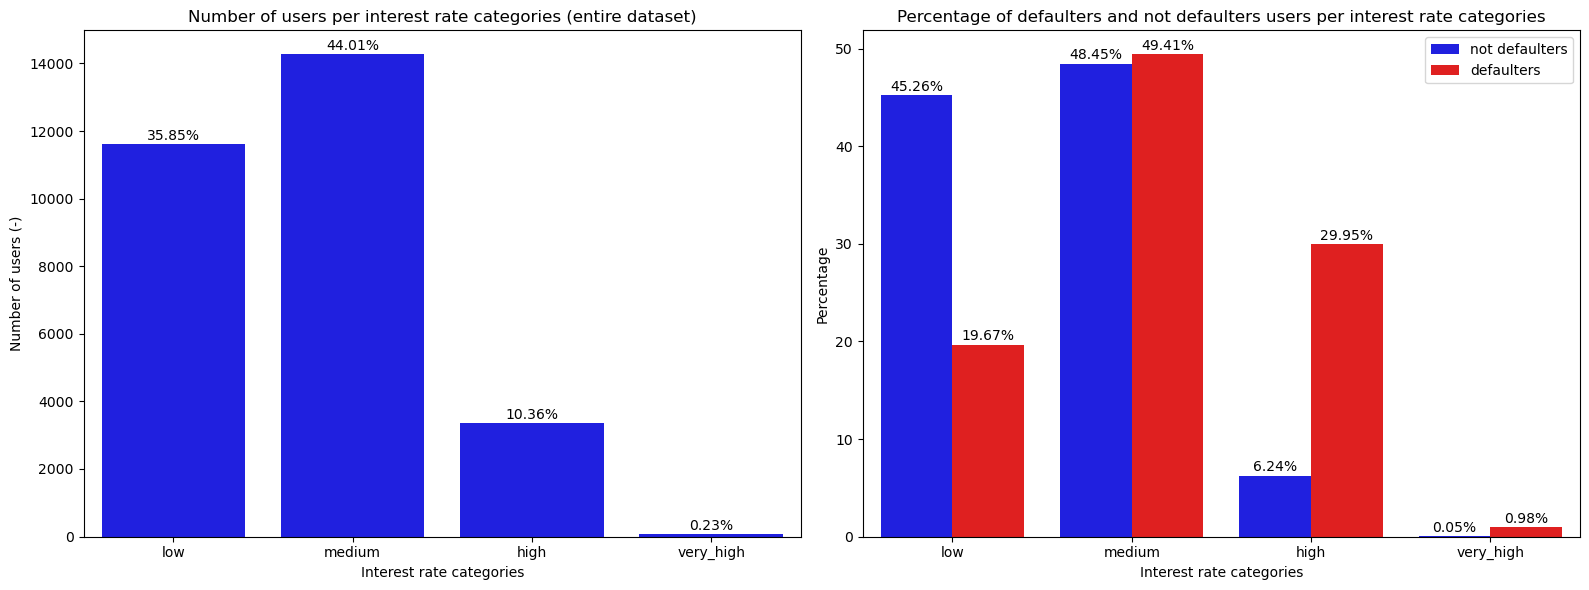

In [74]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'interest_rate_categories', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per interest rate categories (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Interest rate categories", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
#ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="interest_rate_categories", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per interest rate categories", fontsize=12)
ax1 = plt.xlabel("Interest rate categories", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)

# Adjustments
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

- Mostly people which were more to be a defaulter was from high interest rate.

### Credit history length band

In [75]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "cred_hist_length_band"]].groupby("cred_hist_length_band").nunique().\
                                                 reset_index().sort_values("cred_hist_length_band", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# Number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "cred_hist_length_band"]].groupby("cred_hist_length_band").\
                                    nunique().reset_index().sort_values("cred_hist_length_band", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

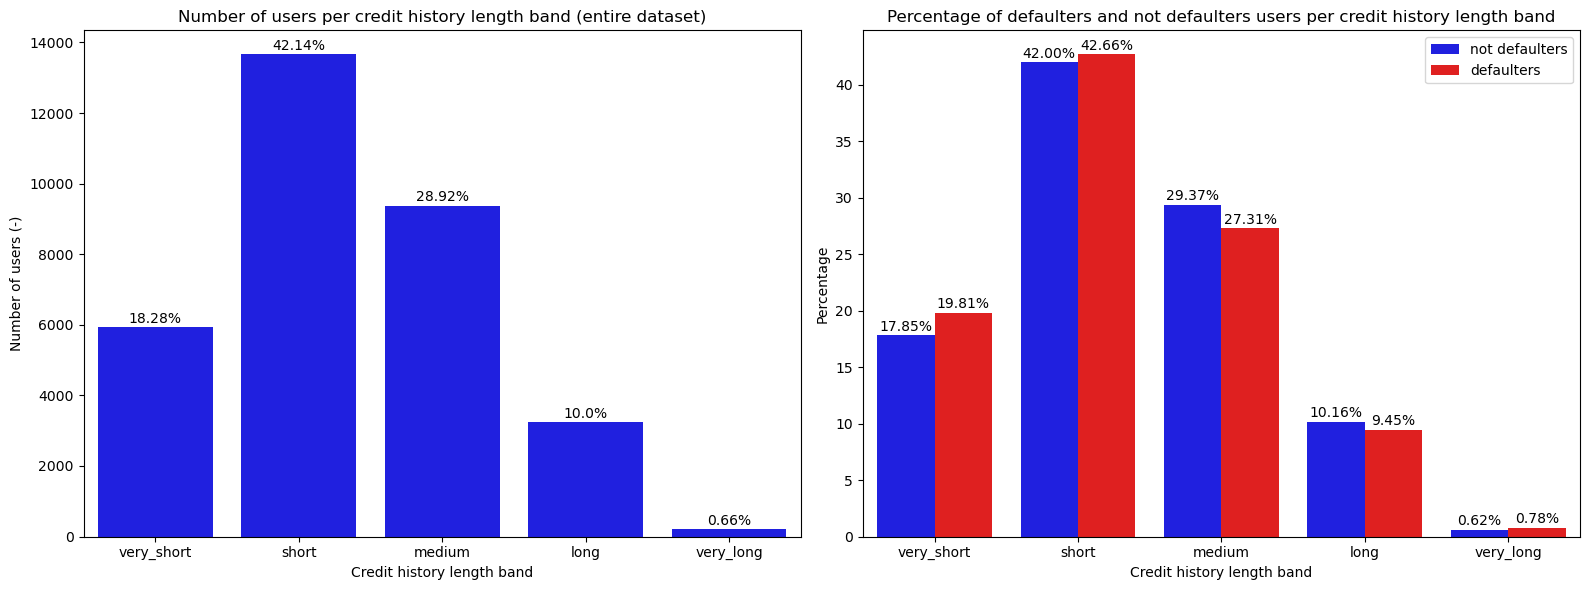

In [76]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'cred_hist_length_band', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per credit history length band (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Credit history length band", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
#ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="cred_hist_length_band", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per credit history length band", fontsize=12)
ax1 = plt.xlabel("Credit history length band", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)

# Adjustments
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

- People with very short credit history length were more prone to be a dedaulter.

## 3.2. Numerical Attributes (continuous)

In [77]:
num_attributes.apply(lambda x: x.unique().shape[0] )

person_age                            58
person_income                       4295
person_emp_length                     37
loan_amnt                            753
loan_int_rate                        349
target                                 2
loan_percent_income                   77
cb_person_cred_hist_length            29
loan_amount_interest_interaction    9731
income_per_loan                     7064
dtype: int64

### Person age

In [78]:
# not defaulters users
aux1 = df3[df3["target"] == 0][["user_id", "person_age"]]
aux1["category"] = "not defaulters"

# defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "person_age"]]
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

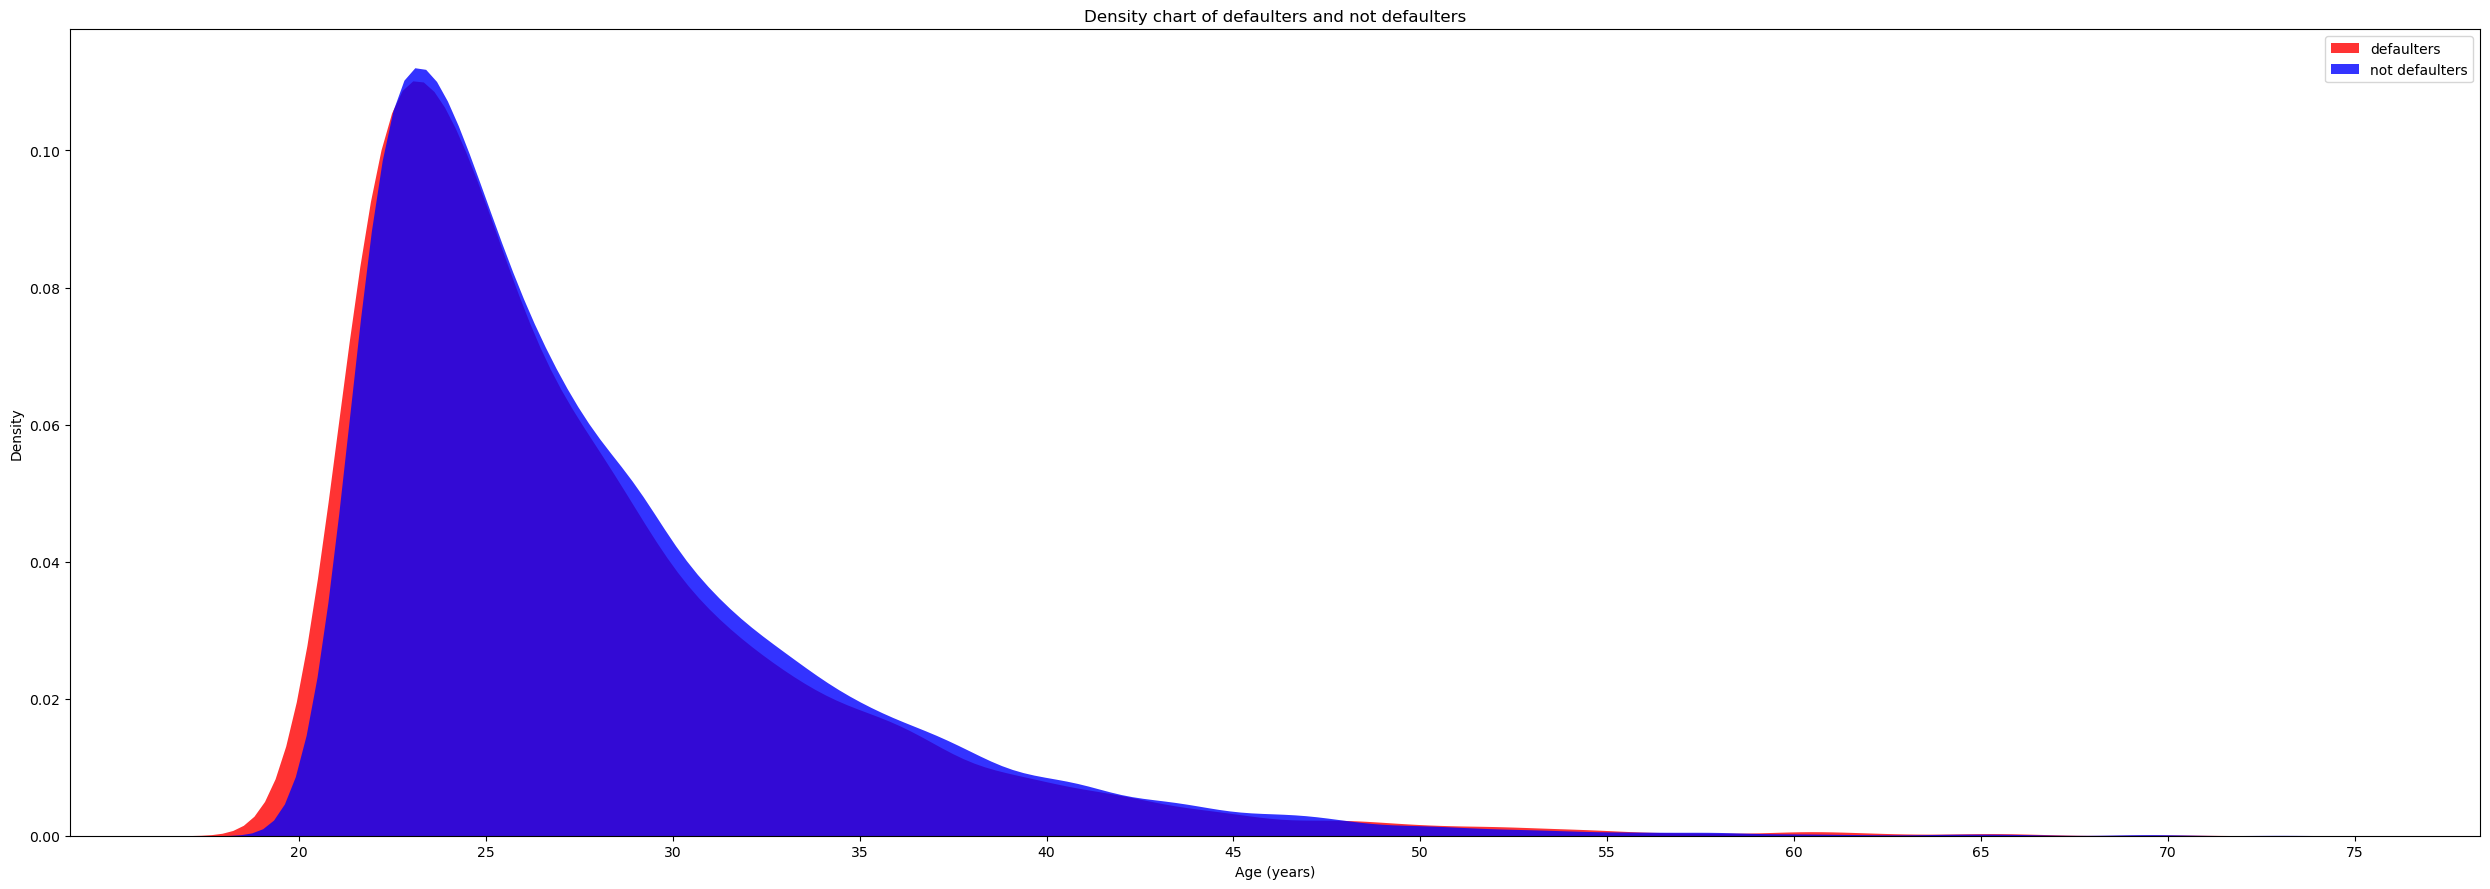

In [81]:
# Chart dimensions
fig, ax = plt.subplots(figsize = (25, 9))

# Data filtering
aux3 = aux3[(aux3["person_age"].notnull()) & (aux3["person_age"] >= 0)
           & (aux3["person_age"] <= 75)]

# Plot 
sns.kdeplot(data=aux3, x="person_age", hue="category", hue_order=["not defaulters", "defaulters"],
            palette=["blue", "red"], fill=True, alpha=0.8, common_norm=False, linewidth=0)

# Titles
ax.set_title("Density chart of defaulters and not defaulters", fontsize=12)
ax.set_xlabel("Age (years)", fontsize=10)
ax.set_ylabel("Density", fontsize=10)

# Adjustments
plt.legend(labels=["defaulters", "not defaulters"], loc="upper right")
plt.tight_layout()

# changing x-axis grading
min_value = int(min(aux3["person_age"]))
max_value = int(max(aux3["person_age"]))
plt.xticks(range(min_value, max_value + 5, 5))
# plt.xticks(rotation=90)

# display chart
plt.show()

- People around 20 years old were more prone to be a defaulter.

In [82]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(df3[(df3["target"] == 1)]["person_age"]).describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,7089.00,27.47,6.26,20.00,23.00,26.00,30.00,70.00


- Range where we could find defaulters: around 20 years old.
- Median age for defaulters: 26 yo.
- Average age for defaulters: 27 yo.

### Person income

In [83]:
# not defaulters users
aux1 = df3[df3["target"] == 0][["user_id", "person_income"]]
aux1["category"] = "not defaulters"

# defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "person_income"]]
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

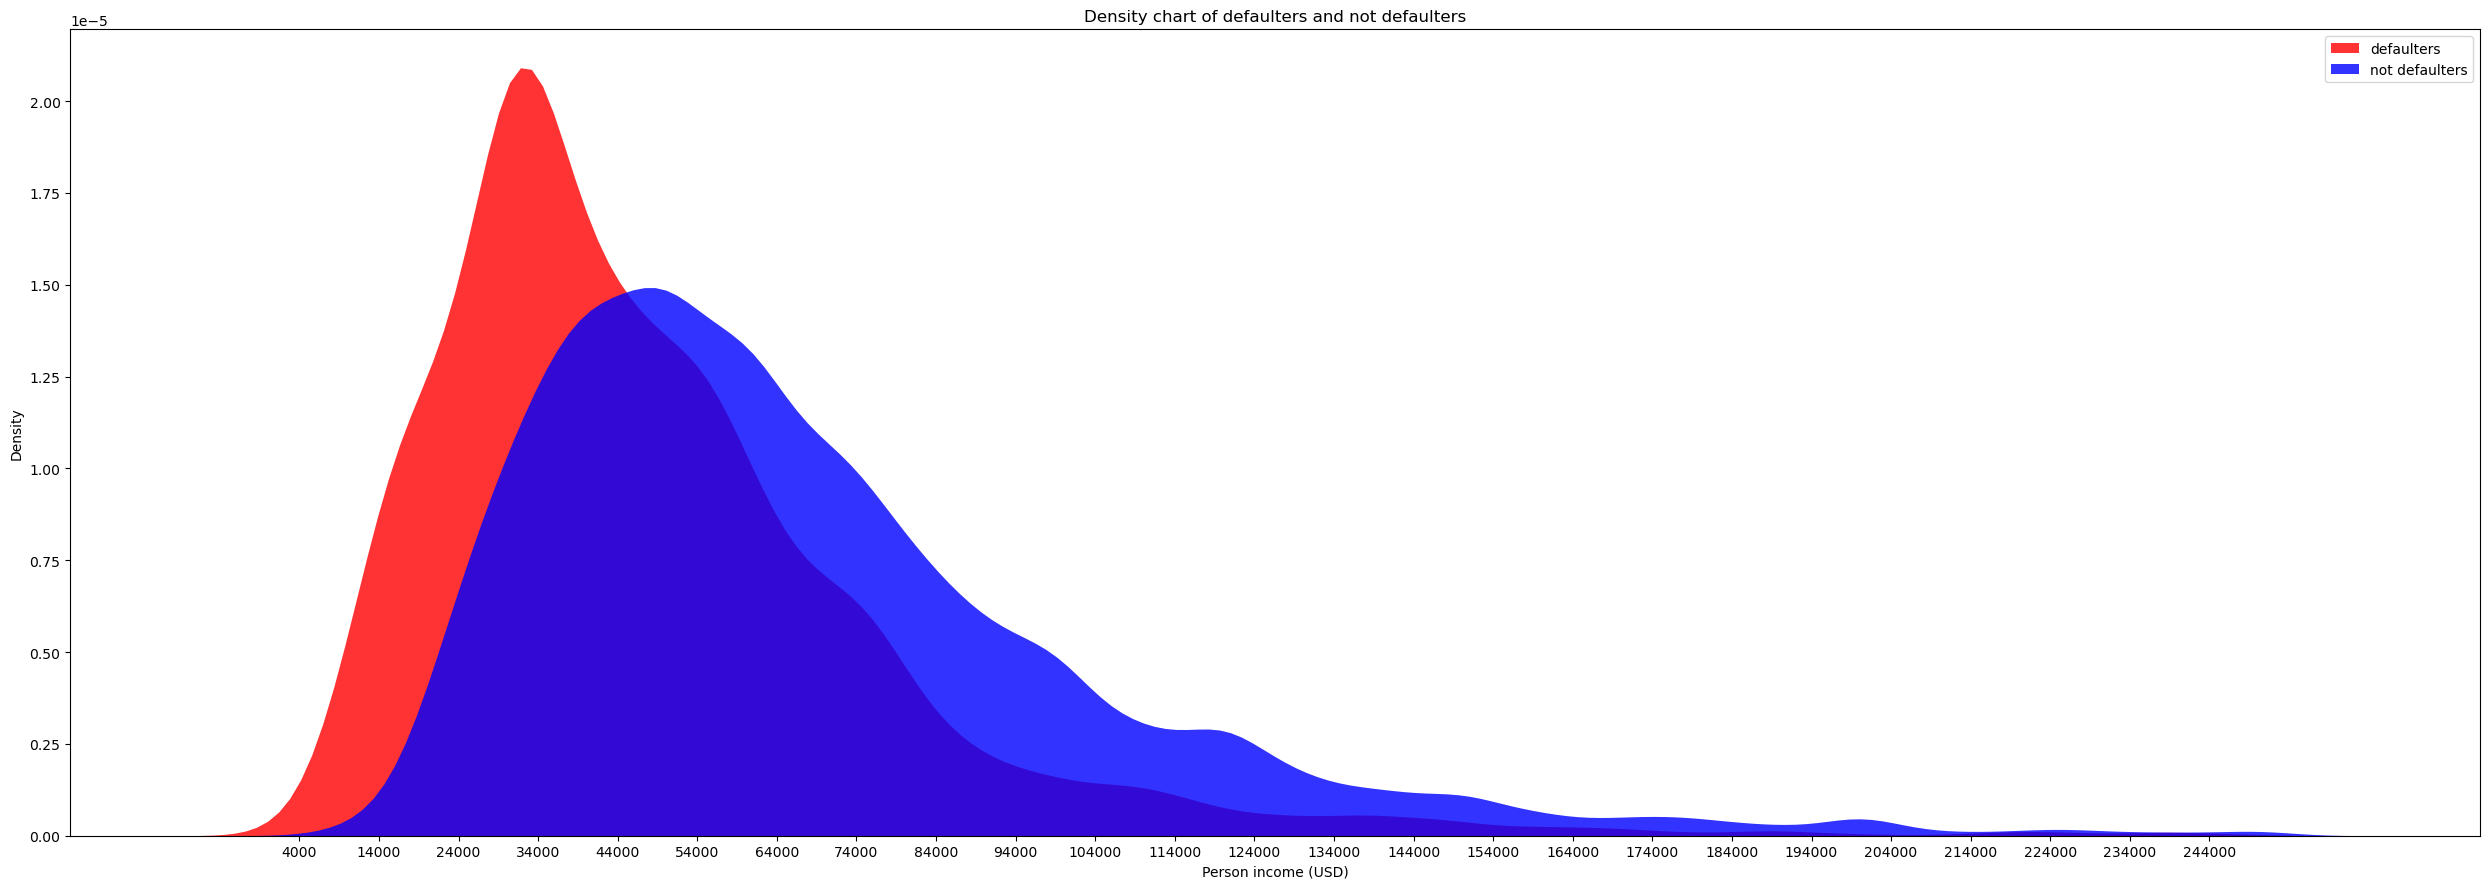

In [87]:
# Chart dimensions
fig, ax = plt.subplots(figsize = (25, 9))

# Data filtering
aux3 = aux3[(aux3["person_income"].notnull()) & (aux3["person_income"] >= 0)
           & (aux3["person_income"] <= 250000)]

# Plot 
sns.kdeplot(data=aux3, x="person_income", hue="category", hue_order=["not defaulters", "defaulters"],
            palette=["blue", "red"], fill=True, alpha=0.8, common_norm=False, linewidth=0)

# Titles
ax.set_title("Density chart of defaulters and not defaulters", fontsize=12)
ax.set_xlabel("Person income (USD)", fontsize=10)
ax.set_ylabel("Density", fontsize=10)

# Adjustments
plt.legend(labels=["defaulters", "not defaulters"], loc="upper right")
plt.tight_layout()

# changing x-axis grading
min_value = int(min(aux3["person_income"]))
max_value = int(max(aux3["person_income"]))
plt.xticks(range(min_value, max_value + 50, 10000))
# plt.xticks(rotation=90)

# display chart
plt.show()

In [88]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(df3[(df3["target"] == 1)]["person_income"]).describe().T

,count,mean,std,min,25%,50%,75%,max
person_income,7089.00,49094.50,36342.35,4000.00,30000.00,41682.00,59600.00,703800.00


- People with income lower than 44000 were more prone to be a defaulter.
- Median income for a defaulter: 41000.
- Average income for a defaulter: 49000.

### Person employment length

In [89]:
# not defaulters users
aux1 = df3[df3["target"] == 0][["user_id", "person_emp_length"]]
aux1["category"] = "not defaulters"

# defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "person_emp_length"]]
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

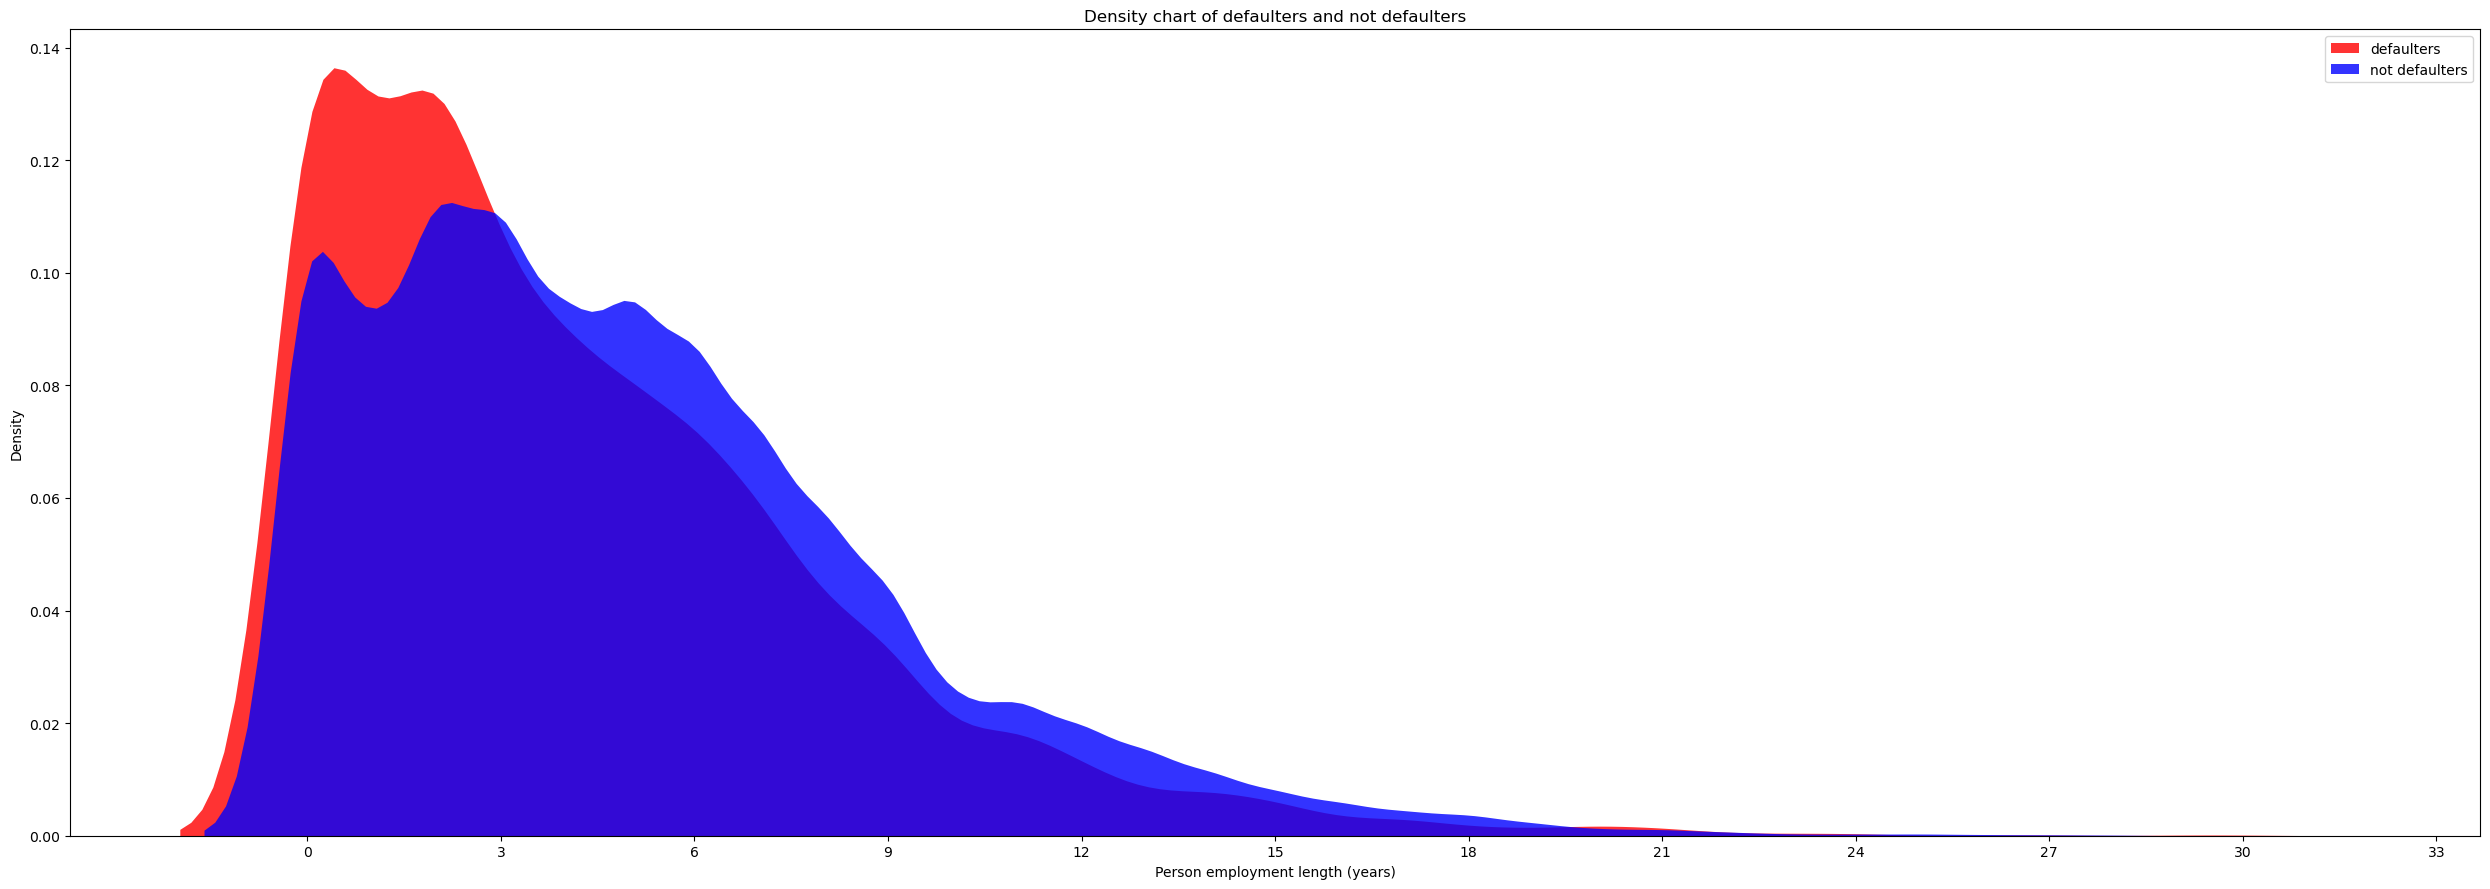

In [92]:
# Chart dimensions
fig, ax = plt.subplots(figsize = (25, 9))

# Data filtering
aux3 = aux3[(aux3["person_emp_length"].notnull()) & (aux3["person_emp_length"] >= 0)
           & (aux3["person_emp_length"] <= 30)]

# Plot 
sns.kdeplot(data=aux3, x="person_emp_length", hue="category", hue_order=["not defaulters", "defaulters"],
            palette=["blue", "red"], fill=True, alpha=0.8, common_norm=False, linewidth=0)

# Titles
ax.set_title("Density chart of defaulters and not defaulters", fontsize=12)
ax.set_xlabel("Person employment length (years)", fontsize=10)
ax.set_ylabel("Density", fontsize=10)

# Adjustments
plt.legend(labels=["defaulters", "not defaulters"], loc="upper right")
plt.tight_layout()

# changing x-axis grading
min_value = int(min(aux3["person_emp_length"]))
max_value = int(max(aux3["person_emp_length"]))
plt.xticks(range(min_value, max_value + 5, 3))
# plt.xticks(rotation=90)

# display chart
plt.show()

In [93]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(df3[(df3["target"] == 1)]["person_emp_length"]).describe().T

,count,mean,std,min,25%,50%,75%,max
person_emp_length,7089.00,3.93,4.17,-1.00,1.00,3.00,6.00,123.00


- People with lesse than 3 years of employment were more prone to be a defaulter.
- Median employment length: 3.
- Average employment length: 4.

### Loan amount

In [94]:
# not defaulters users
aux1 = df3[df3["target"] == 0][["user_id", "loan_amnt"]]
aux1["category"] = "not defaulters"

# defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "loan_amnt"]]
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

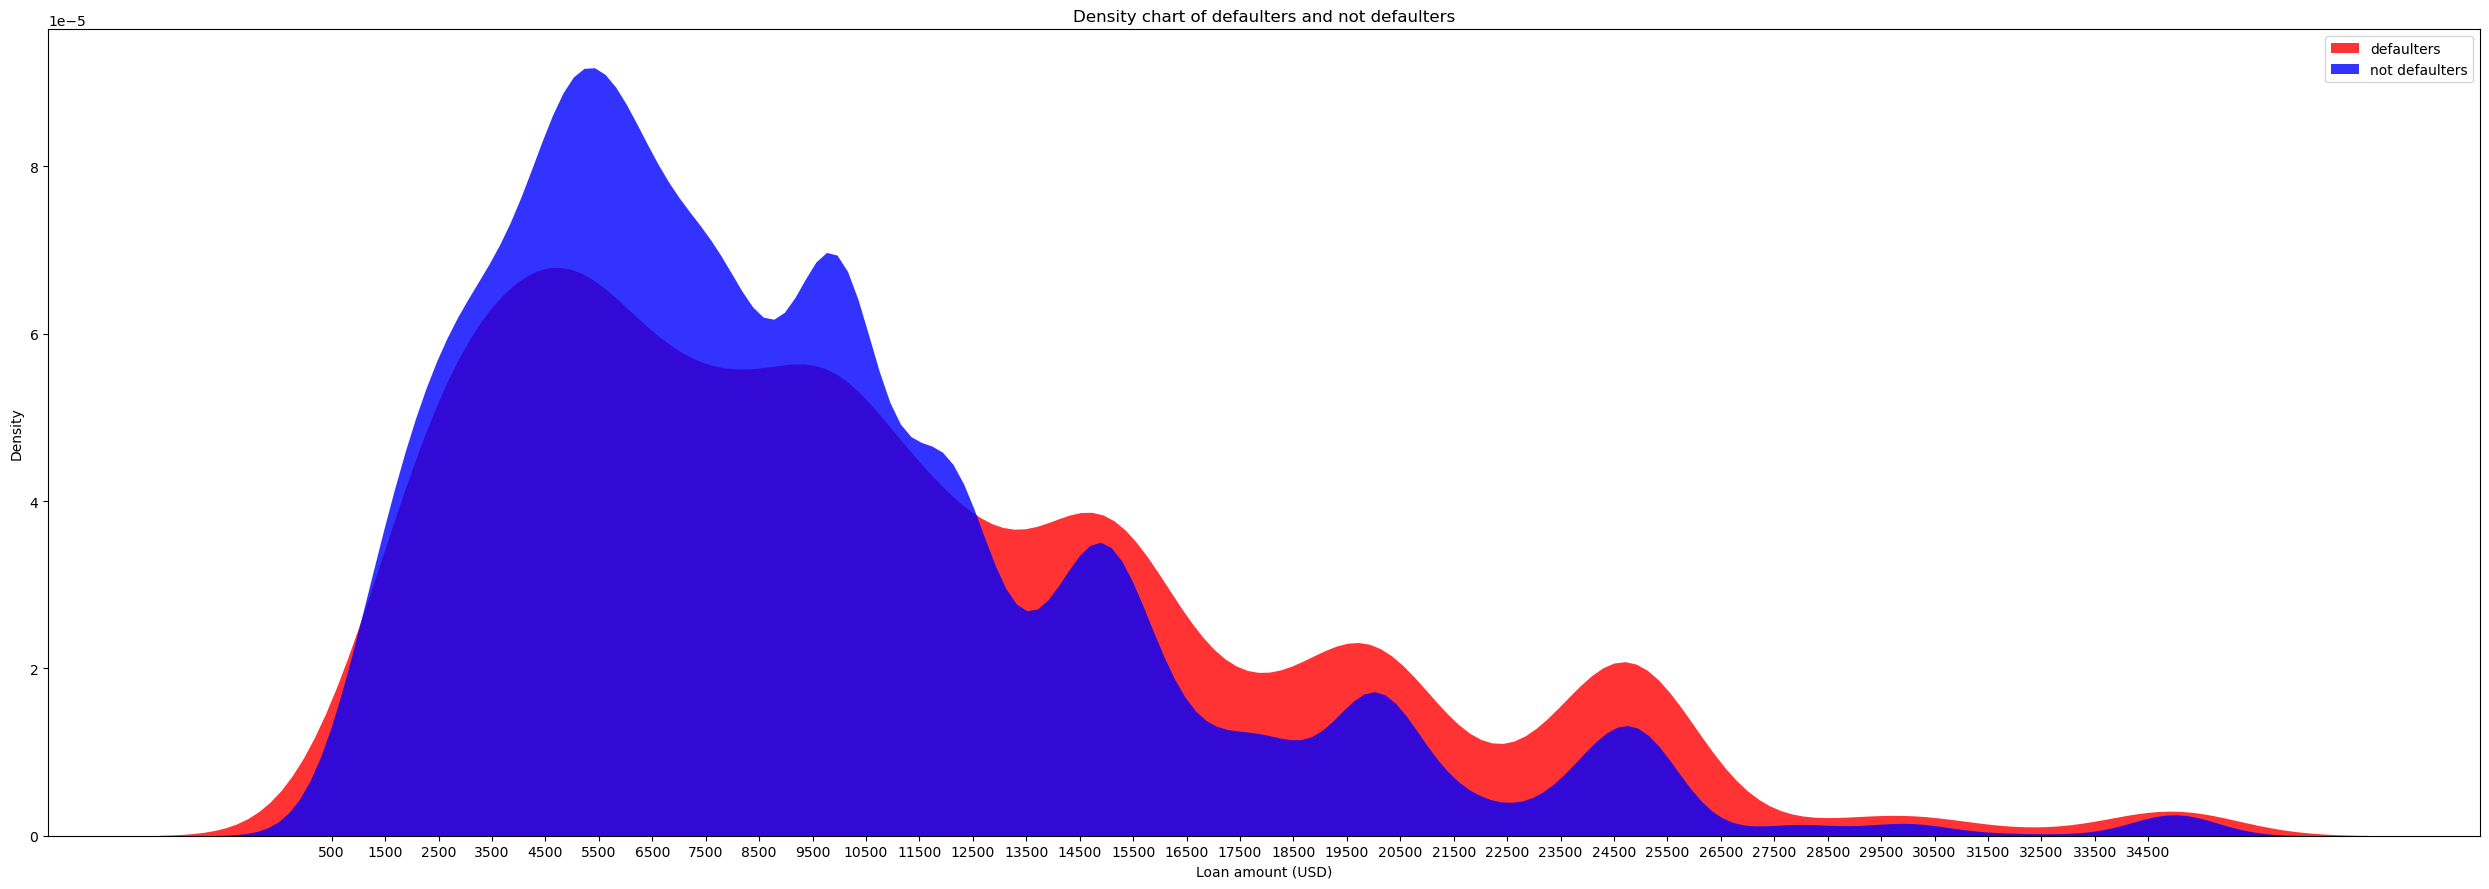

In [97]:
# Chart dimensions
fig, ax = plt.subplots(figsize = (25, 9))

# # Data filtering
# aux3 = aux3[(aux3["loan_amnt"].notnull()) & (aux3["loan_amnt"] >= 0)
#            & (aux3["loan_amnt"] <= 30)]

# Plot 
sns.kdeplot(data=aux3, x="loan_amnt", hue="category", hue_order=["not defaulters", "defaulters"],
            palette=["blue", "red"], fill=True, alpha=0.8, common_norm=False, linewidth=0)

# Titles
ax.set_title("Density chart of defaulters and not defaulters", fontsize=12)
ax.set_xlabel("Loan amount (USD)", fontsize=10)
ax.set_ylabel("Density", fontsize=10)

# Adjustments
plt.legend(labels=["defaulters", "not defaulters"], loc="upper right")
plt.tight_layout()

# changing x-axis grading
min_value = int(min(aux3["loan_amnt"]))
max_value = int(max(aux3["loan_amnt"]))
plt.xticks(range(min_value, max_value + 50, 1000))
# plt.xticks(rotation=90)

# display chart
plt.show()

In [98]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(df3[(df3["target"] == 1)]["loan_amnt"]).describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,7089.00,10857.48,7143.83,900.00,5000.00,9600.00,15000.00,35000.00


- People with loan amount higher than 12000 USD were more prone to be a defaulter.
- Median loan amount: 9600 USD.
- Average loan amount: 10800 USD.

### Loan interest rate

In [99]:
# not defaulters users
aux1 = df3[df3["target"] == 0][["user_id", "loan_int_rate"]]
aux1["category"] = "not defaulters"

# defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "loan_int_rate"]]
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

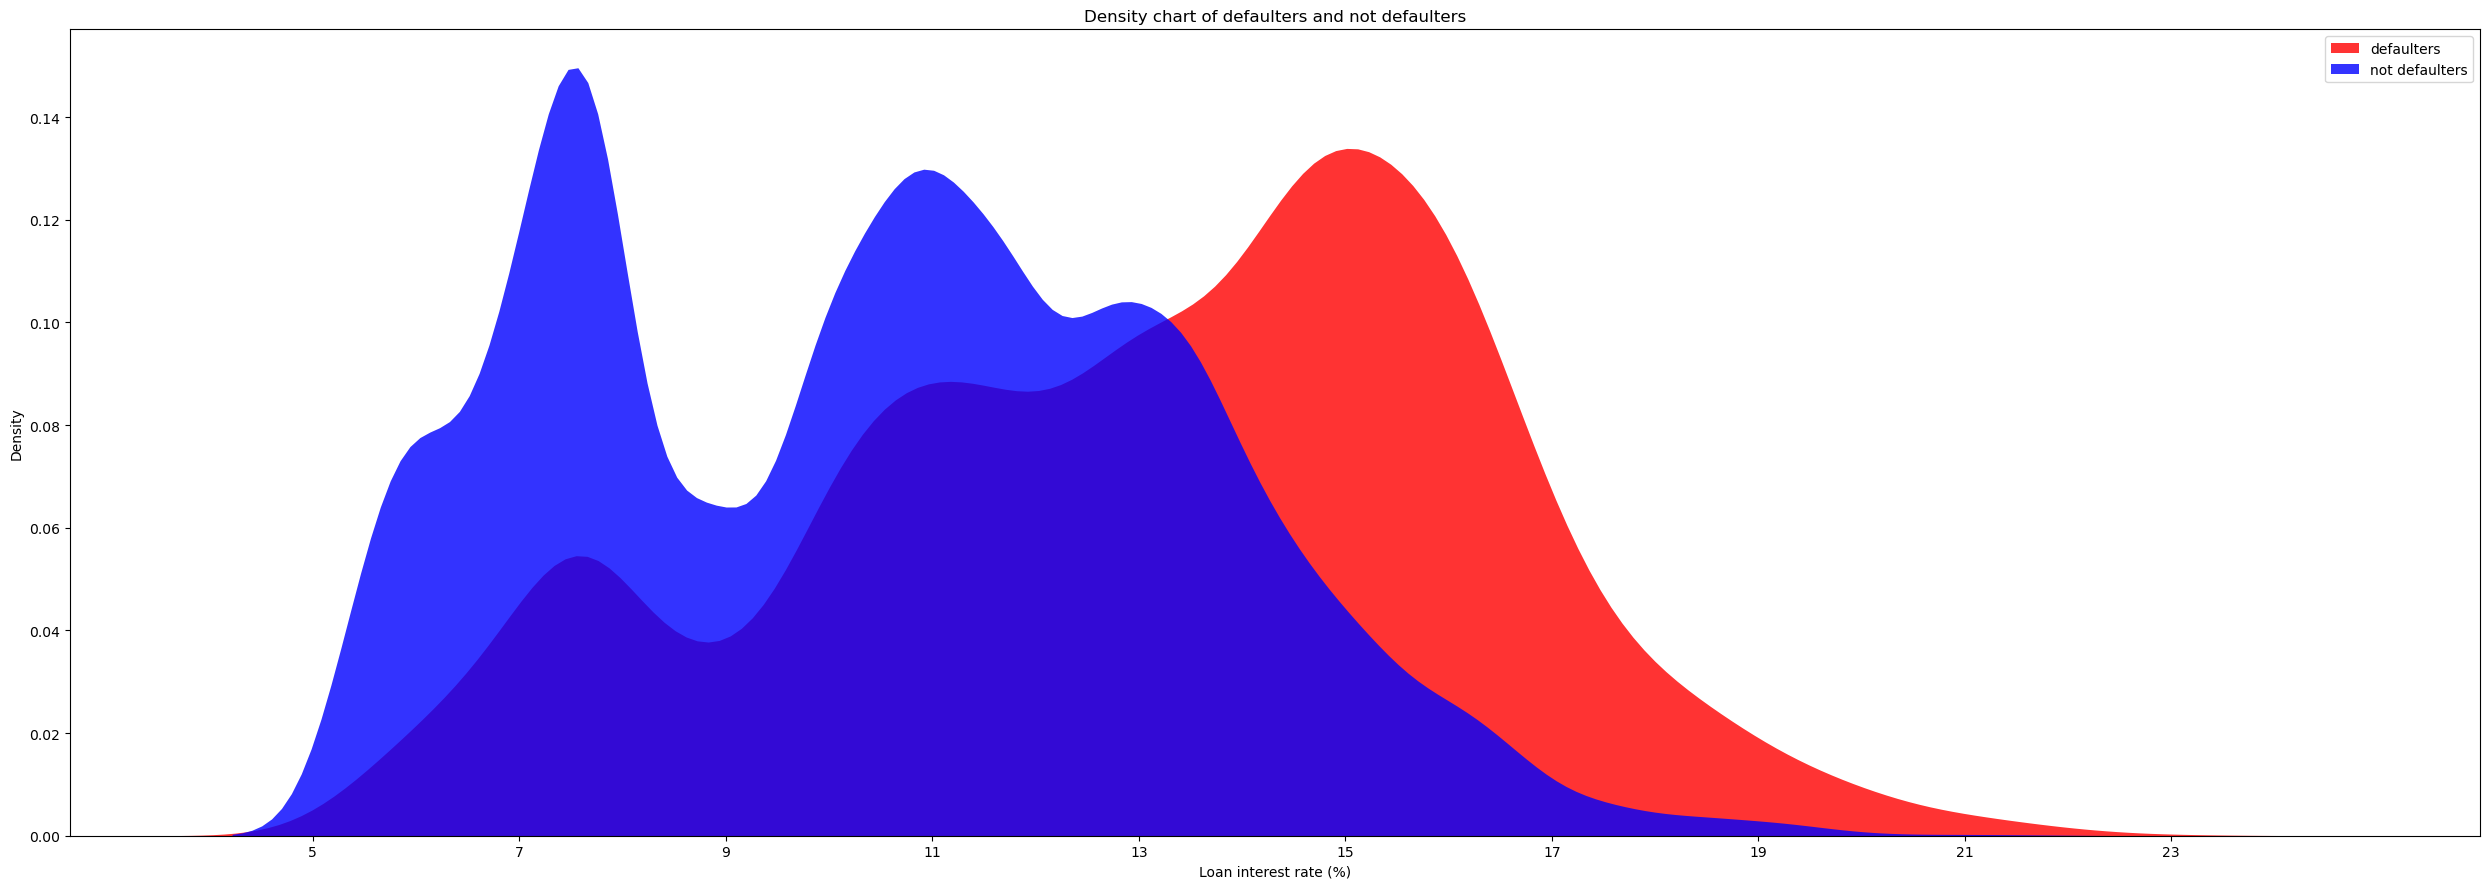

In [102]:
# Chart dimensions
fig, ax = plt.subplots(figsize = (25, 9))

# Data filtering
aux3 = aux3[(aux3["loan_int_rate"].notnull()) & (aux3["loan_int_rate"] >= 0)]

# Plot 
sns.kdeplot(data=aux3, x="loan_int_rate", hue="category", hue_order=["not defaulters", "defaulters"],
            palette=["blue", "red"], fill=True, alpha=0.8, common_norm=False, linewidth=0)

# Titles
ax.set_title("Density chart of defaulters and not defaulters", fontsize=12)
ax.set_xlabel("Loan interest rate (%)", fontsize=10)
ax.set_ylabel("Density", fontsize=10)

# Adjustments
plt.legend(labels=["defaulters", "not defaulters"], loc="upper right")
plt.tight_layout()

# changing x-axis grading
min_value = int(min(aux3["loan_int_rate"]))
max_value = int(max(aux3["loan_int_rate"]))
plt.xticks(range(min_value, max_value + 2, 2))
# plt.xticks(rotation=90)

# display chart
plt.show()

In [103]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(df3[(df3["target"] == 1)]["loan_int_rate"]).describe().T

,count,mean,std,min,25%,50%,75%,max
loan_int_rate,7089.00,11.80,5.11,-1.00,9.91,12.99,15.31,23.22


- People with loan interest rate higher than 13 were more prone to be a defaulter.
- Median loan interest rate: 13%.
- Average loan interest rate: 12.80%.

### Loan percentage income

In [104]:
# not defaulters users
aux1 = df3[df3["target"] == 0][["user_id", "loan_percent_income"]]
aux1["category"] = "not defaulters"

# defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "loan_percent_income"]]
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

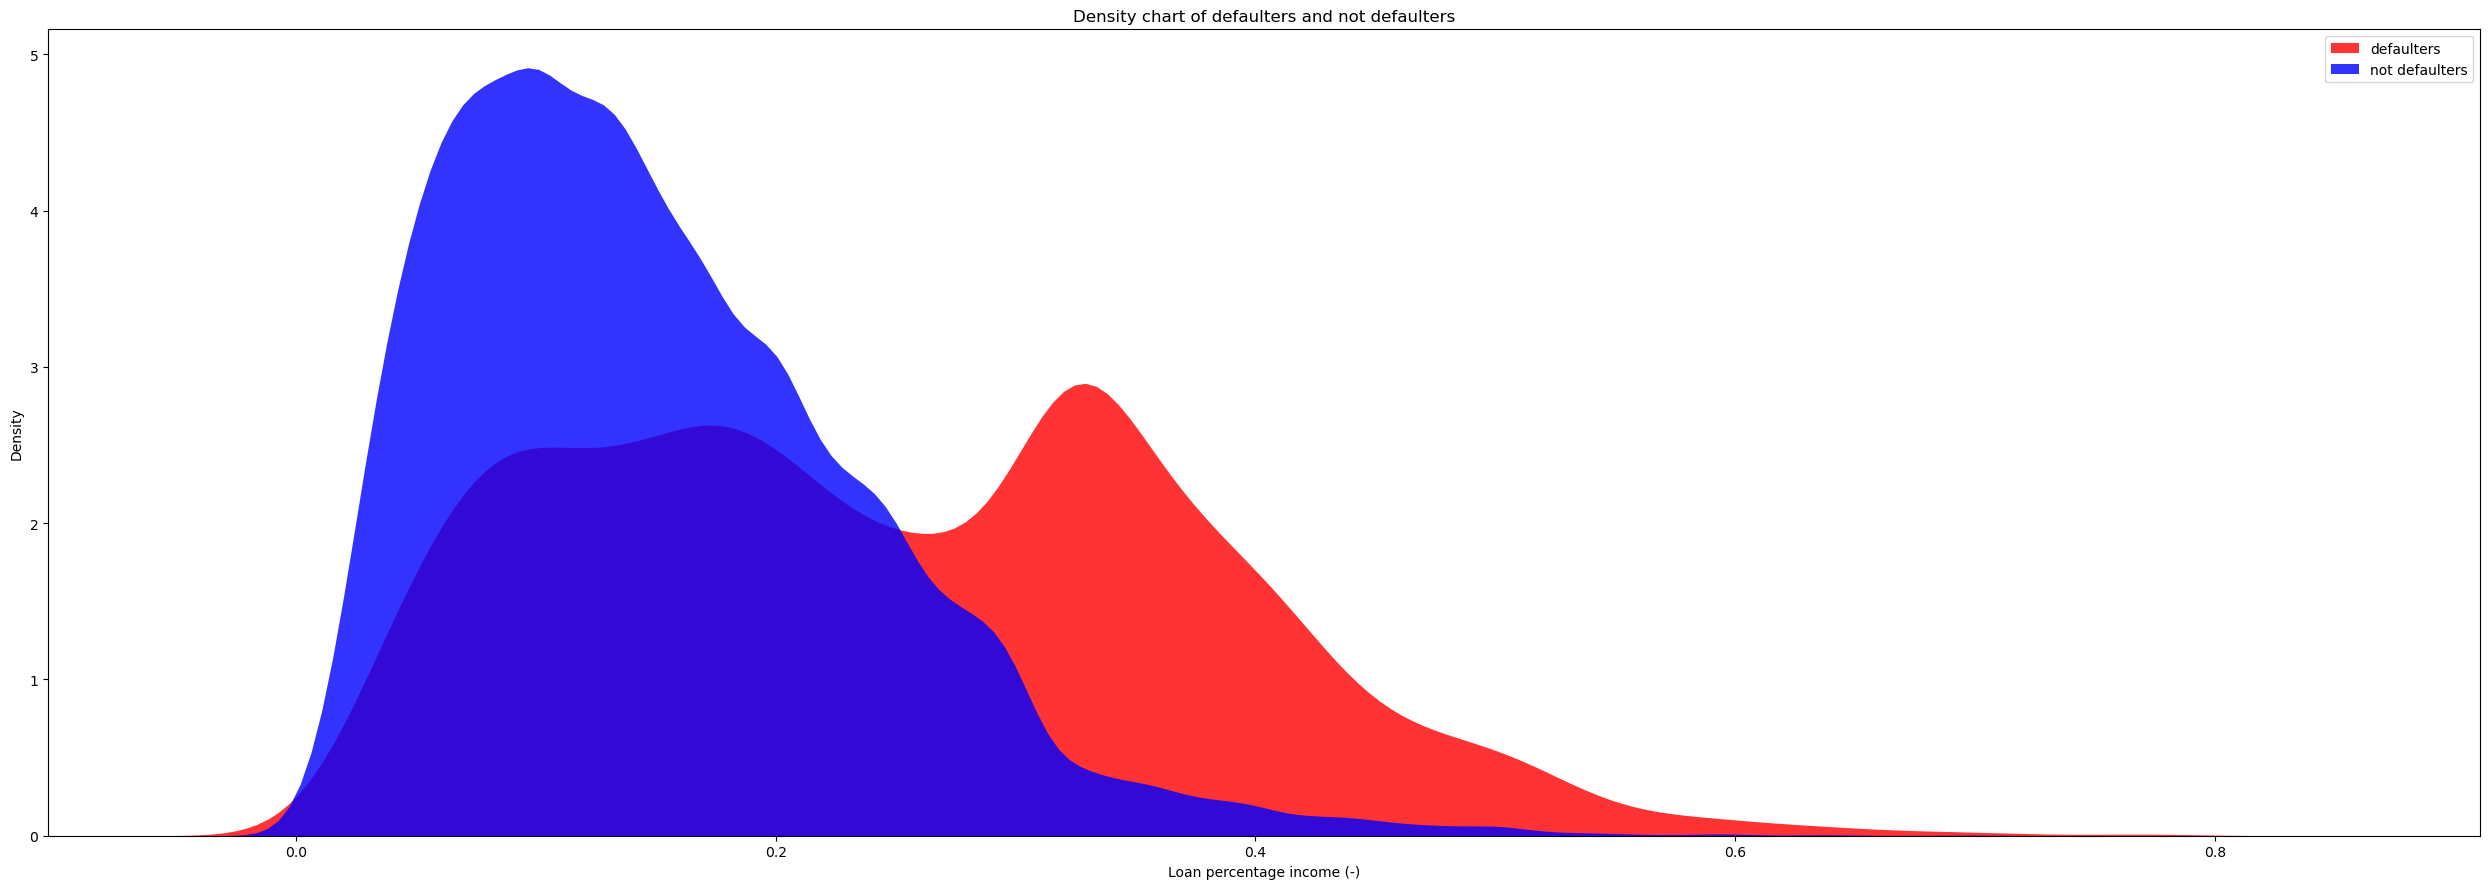

In [106]:
# Chart dimensions
fig, ax = plt.subplots(figsize = (25, 9))

# # Data filtering
# aux3 = aux3[(aux3["loan_percent_income"].notnull()) & (aux3["loan_percent_income"] >= 0)]

# Plot 
sns.kdeplot(data=aux3, x="loan_percent_income", hue="category", hue_order=["not defaulters", "defaulters"],
            palette=["blue", "red"], fill=True, alpha=0.8, common_norm=False, linewidth=0)

# Titles
ax.set_title("Density chart of defaulters and not defaulters", fontsize=12)
ax.set_xlabel("Loan percentage income (-)", fontsize=10)
ax.set_ylabel("Density", fontsize=10)

# Adjustments
plt.legend(labels=["defaulters", "not defaulters"], loc="upper right")
plt.tight_layout()

# changing x-axis grading
min_value = int(min(aux3["loan_percent_income"]))
max_value = int(max(aux3["loan_percent_income"]))
# plt.xticks(range(min_value, max_value + 2, 2))
# plt.xticks(rotation=90)

# display chart
plt.show()

In [107]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(df3[(df3["target"] == 1)]["loan_percent_income"]).describe().T

,count,mean,std,min,25%,50%,75%,max
loan_percent_income,7089.00,0.25,0.13,0.01,0.14,0.24,0.34,0.78


- People with loan amount higher than 25% of the income were more prone to be a defaulter.
- Median loan percentage income: 24%.
- Average loan percentage income: 25%.

### Credit history length

In [108]:
# not defaulters users
aux1 = df3[df3["target"] == 0][["user_id", "cb_person_cred_hist_length"]]
aux1["category"] = "not defaulters"

# defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "cb_person_cred_hist_length"]]
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

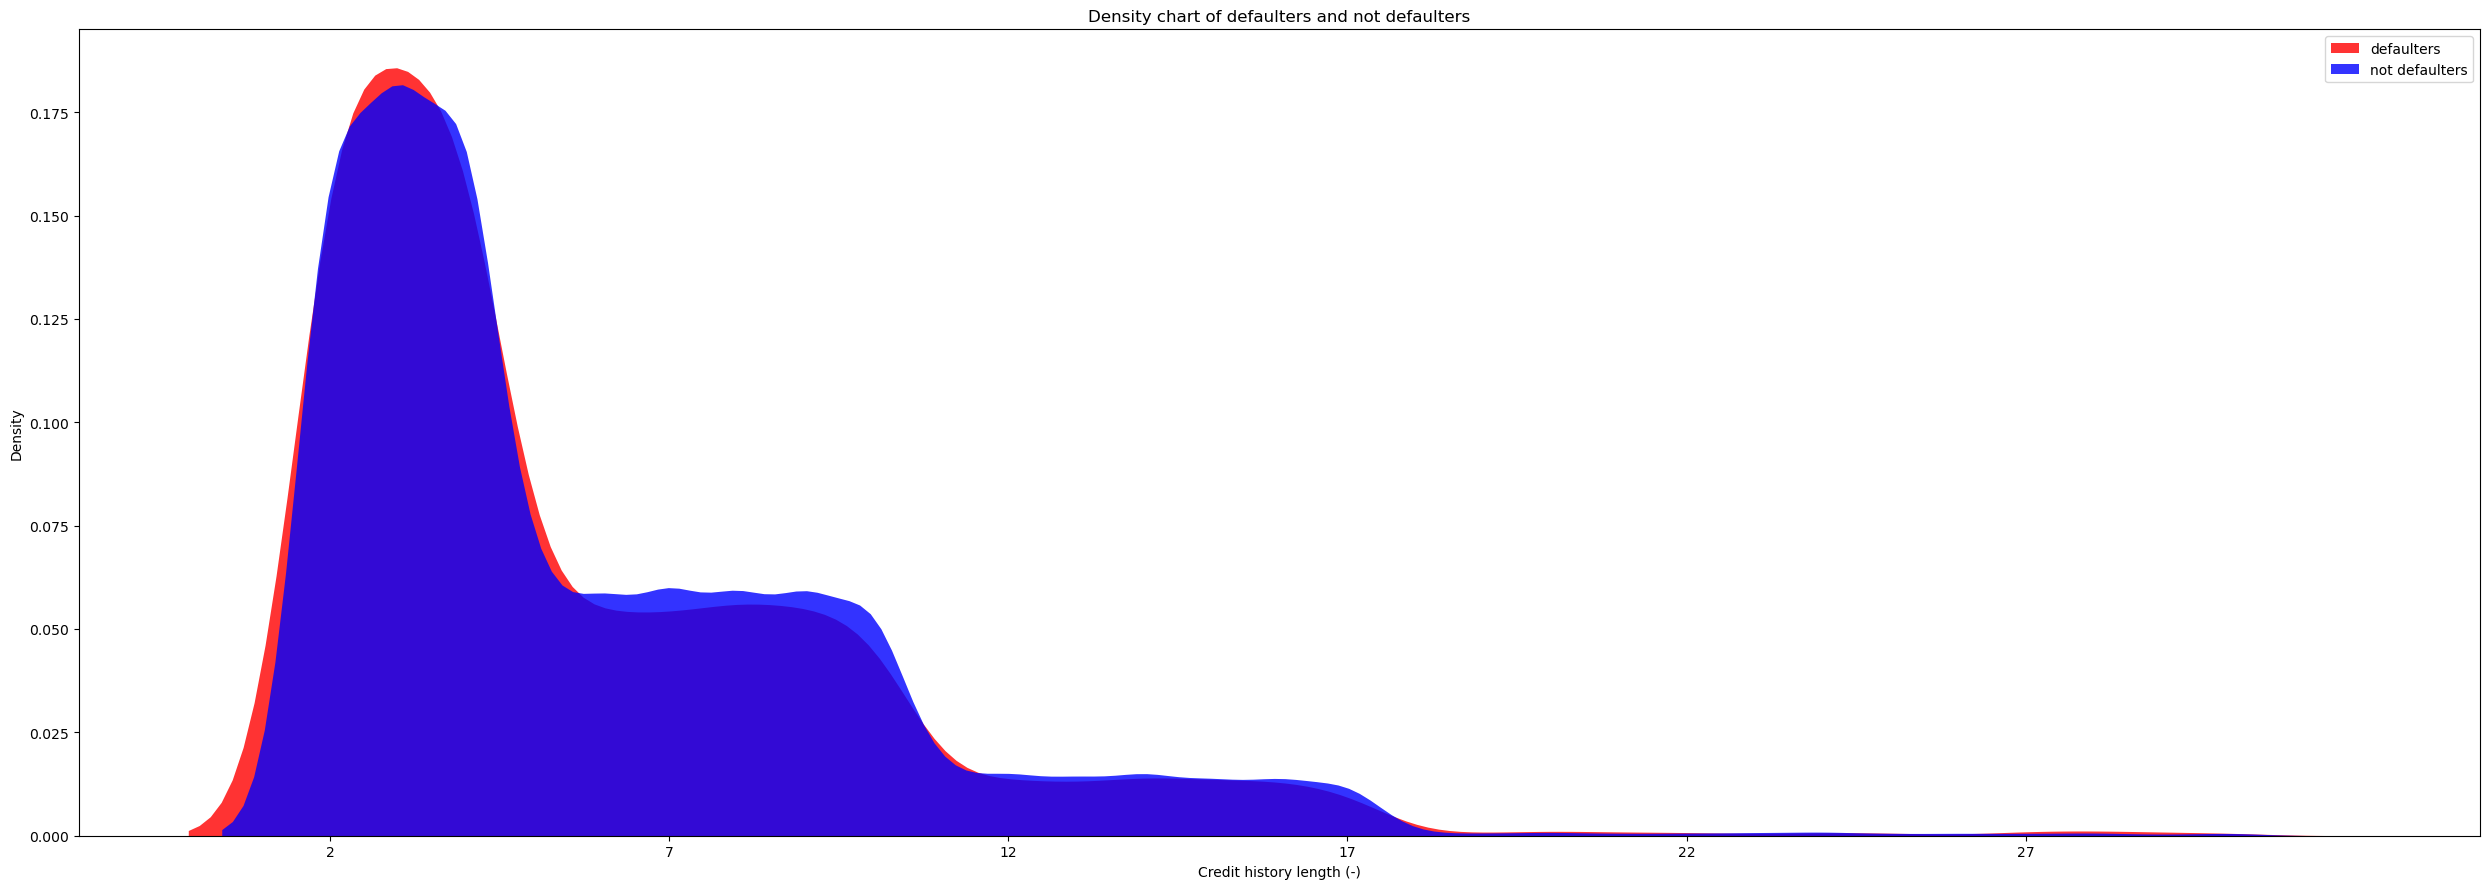

In [109]:
# Chart dimensions
fig, ax = plt.subplots(figsize = (25, 9))

# # Data filtering
# aux3 = aux3[(aux3["cb_person_cred_hist_length"].notnull()) & (aux3["cb_person_cred_hist_length"] >= 0)]

# Plot 
sns.kdeplot(data=aux3, x="cb_person_cred_hist_length", hue="category", hue_order=["not defaulters", "defaulters"],
            palette=["blue", "red"], fill=True, alpha=0.8, common_norm=False, linewidth=0)

# Titles
ax.set_title("Density chart of defaulters and not defaulters", fontsize=12)
ax.set_xlabel("Credit history length (-)", fontsize=10)
ax.set_ylabel("Density", fontsize=10)

# Adjustments
plt.legend(labels=["defaulters", "not defaulters"], loc="upper right")
plt.tight_layout()

# changing x-axis grading
min_value = int(min(aux3["cb_person_cred_hist_length"]))
max_value = int(max(aux3["cb_person_cred_hist_length"]))
plt.xticks(range(min_value, max_value + 2, 5))
# plt.xticks(rotation=90)

# display chart
plt.show()

In [110]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(df3[(df3["target"] == 1)]["cb_person_cred_hist_length"]).describe().T

,count,mean,std,min,25%,50%,75%,max
cb_person_cred_hist_length,7089.00,5.68,4.10,2.00,3.00,4.00,8.00,30.00


- This variable is not informative.

### Loan and interest interaction

In [111]:
# not defaulters users
aux1 = df3[df3["target"] == 0][["user_id", "loan_amount_interest_interaction"]]
aux1["category"] = "not defaulters"

# defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "loan_amount_interest_interaction"]]
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

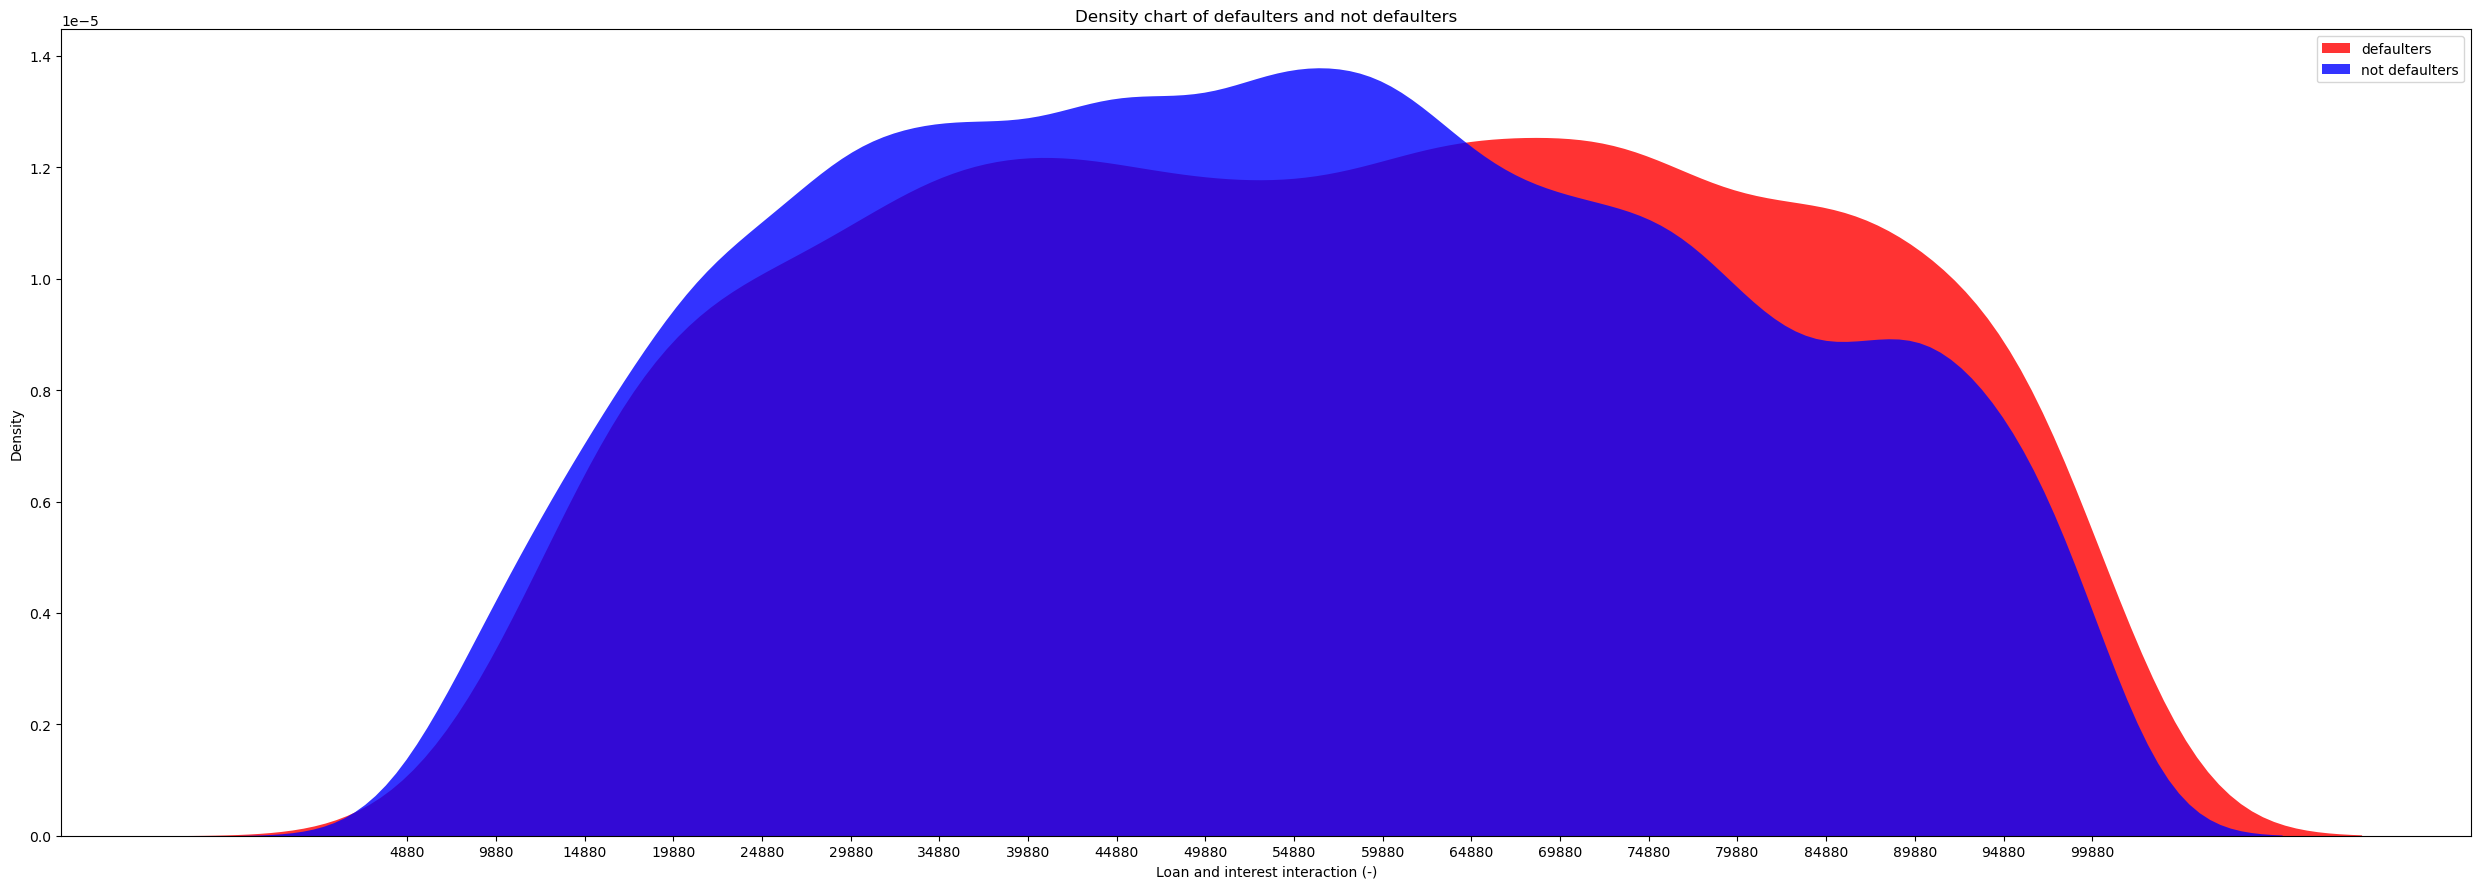

In [116]:
# Chart dimensions
fig, ax = plt.subplots(figsize = (25, 9))

# Data filtering
aux3 = aux3[(aux3["loan_amount_interest_interaction"].notnull()) 
                & (aux3["loan_amount_interest_interaction"] >= 0)
                & (aux3["loan_amount_interest_interaction"] <= 100000)]

# Plot 
sns.kdeplot(data=aux3, x="loan_amount_interest_interaction", hue="category", hue_order=["not defaulters", "defaulters"],
            palette=["blue", "red"], fill=True, alpha=0.8, common_norm=False, linewidth=0)

# Titles
ax.set_title("Density chart of defaulters and not defaulters", fontsize=12)
ax.set_xlabel("Loan and interest interaction (-)", fontsize=10)
ax.set_ylabel("Density", fontsize=10)

# Adjustments
plt.legend(labels=["defaulters", "not defaulters"], loc="upper right")
plt.tight_layout()

# changing x-axis grading
min_value = int(min(aux3["loan_amount_interest_interaction"]))
max_value = int(max(aux3["loan_amount_interest_interaction"]))
plt.xticks(range(min_value, max_value + 50, 5000))
# plt.xticks(rotation=90)

# display chart
plt.show()

In [117]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(df3[(df3["target"] == 1)]["loan_amount_interest_interaction"]).describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amount_interest_interaction,7089.00,130344.38,114159.70,-35000.00,48780.00,103360.00,183936.00,708750.00


- People with this interaction higher than 64000 USD were more prone to be a defaulter.
- Median interaction for a defaulter: 103000 USD.
- Average interaction for a defaulter: 103000 USD.

### Income per loan

In [118]:
# not defaulters users
aux1 = df3[df3["target"] == 0][["user_id", "income_per_loan"]]
aux1["category"] = "not defaulters"

# defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "income_per_loan"]]
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

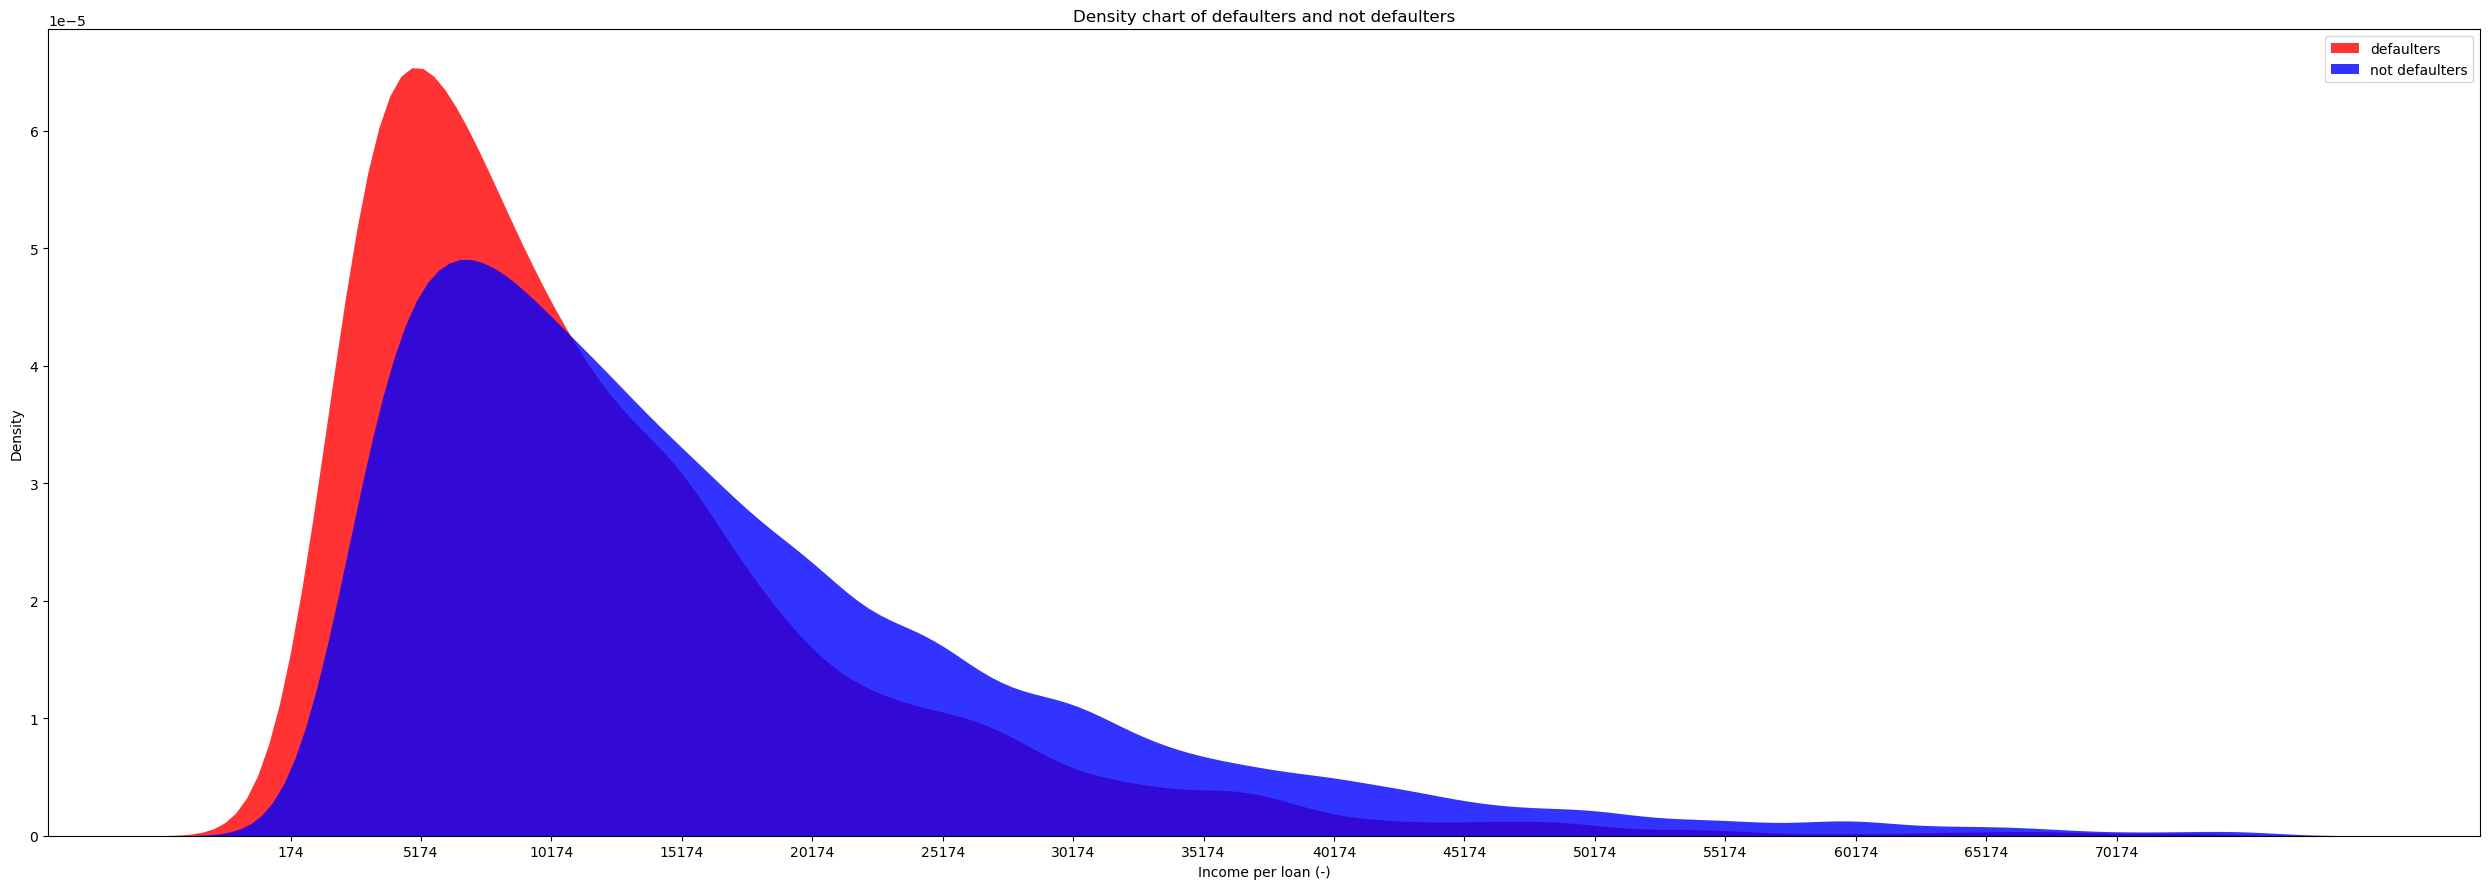

In [120]:
# Chart dimensions
fig, ax = plt.subplots(figsize = (25, 9))

# # Data filtering
aux3 = aux3[(aux3["income_per_loan"].notnull()) 
                & (aux3["income_per_loan"] >= 0)
                & (aux3["income_per_loan"] <= 75000)]

# Plot 
sns.kdeplot(data=aux3, x="income_per_loan", hue="category", hue_order=["not defaulters", "defaulters"],
            palette=["blue", "red"], fill=True, alpha=0.8, common_norm=False, linewidth=0)

# Titles
ax.set_title("Density chart of defaulters and not defaulters", fontsize=12)
ax.set_xlabel("Income per loan (-)", fontsize=10)
ax.set_ylabel("Density", fontsize=10)

# Adjustments
plt.legend(labels=["defaulters", "not defaulters"], loc="upper right")
plt.tight_layout()

# changing x-axis grading
min_value = int(min(aux3["income_per_loan"]))
max_value = int(max(aux3["income_per_loan"]))
plt.xticks(range(min_value, max_value + 50, 5000))
# plt.xticks(rotation=90)

# display chart
plt.show()

In [121]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(df3[(df3["target"] == 1)]["income_per_loan"]).describe().T

,count,mean,std,min,25%,50%,75%,max
income_per_loan,7089.00,12270.98,10505.21,174.57,5000.00,9376.00,16000.00,119000.00


- People with amount of income over amount of loan lower than 10000 were more prone to be a defaulter.
- Median: 9000.
- Mean: 12000.

## 3.3. Numerical Attributes (discrete)

In [122]:
num_attributes.apply(lambda x: x.unique().shape[0] )

person_age                            58
person_income                       4295
person_emp_length                     37
loan_amnt                            753
loan_int_rate                        349
target                                 2
loan_percent_income                   77
cb_person_cred_hist_length            29
loan_amount_interest_interaction    9731
income_per_loan                     7064
dtype: int64

Since we have already analyzed all the numerical attributes and just the target have 2 occurrencies, we assume there is no discrete numerical variable to be analyzed.

# 4. Balanced Dataset

In [123]:
df2.isna().sum()

person_age                             0
person_income                          0
person_home_ownership                  0
person_emp_length                      0
loan_amnt                              0
loan_int_rate                          0
target                                 0
loan_percent_income                    0
cb_person_default_on_file              0
cb_person_cred_hist_length             0
age_buckets                            5
income_band                            0
employment_length_categories        4973
interest_rate_categories            3095
loan_intent_DEBTCONSOLIDATION          0
loan_intent_EDUCATION                  0
loan_intent_HOMEIMPROVEMENT            0
loan_intent_MEDICAL                    0
loan_intent_PERSONAL                   0
loan_intent_VENTURE                    0
loan_grade_A                           0
loan_grade_B                           0
loan_grade_C                           0
loan_grade_D                           0
loan_grade_E    

In [125]:
df2["employment_length_categories"].unique()

['very-long-term', 'medium-term', 'short-term', 'long-term', NaN]
Categories (4, object): ['short-term' < 'medium-term' < 'long-term' < 'very-long-term']

In [126]:
df2["interest_rate_categories"].unique()

['high', 'medium', 'low', 'very_high', NaN]
Categories (4, object): ['low' < 'medium' < 'high' < 'very_high']

In [129]:
# convervion
df2["employment_length_categories"] = df2["employment_length_categories"].astype('str')
df2["interest_rate_categories"] = df2["interest_rate_categories"].astype('str')

# missing value treatment
df2["employment_length_categories"] = df2["employment_length_categories"].fillna("SI")
df2["interest_rate_categories"] = df2["interest_rate_categories"].fillna("SI")

In [130]:
df2.isna().sum()

person_age                          0
person_income                       0
person_home_ownership               0
person_emp_length                   0
loan_amnt                           0
loan_int_rate                       0
target                              0
loan_percent_income                 0
cb_person_default_on_file           0
cb_person_cred_hist_length          0
age_buckets                         5
income_band                         0
employment_length_categories        0
interest_rate_categories            0
loan_intent_DEBTCONSOLIDATION       0
loan_intent_EDUCATION               0
loan_intent_HOMEIMPROVEMENT         0
loan_intent_MEDICAL                 0
loan_intent_PERSONAL                0
loan_intent_VENTURE                 0
loan_grade_A                        0
loan_grade_B                        0
loan_grade_C                        0
loan_grade_D                        0
loan_grade_E                        0
loan_grade_F                        0
loan_grade_G

In [131]:
# removing data where variable target is null :: in this case we have no null values but it is commom in prod
df4 = df2.dropna(subset=["target"]).copy()

In [132]:
df4["target"].value_counts(normalize=True)

0   0.78
1   0.22
Name: target, dtype: float64

In [133]:
df4["target"].value_counts()

0    25327
1     7089
Name: target, dtype: int64

In [134]:
num_attributes = df4.select_dtypes(include=['int64']).columns.tolist()

for col in df4.columns:
    if col in num_attributes:
        df4[col] = df4[col].astype('int32')

In [135]:
num_attributes = df4.select_dtypes(include=['float64']).columns.tolist()

for col in df4.columns:
    if col in num_attributes:
        df4[col] = df4[col].astype('float32')

In [136]:
cat_attributes = df4.select_dtypes(include=['object']).columns.tolist()

for col in df4.columns:
    if col in cat_attributes:
        df4[col] = df4[col].astype('str')

In [137]:
del num_attributes
del cat_attributes

## 4.1. Data Balance: random oversampling

In [138]:
df4.apply(lambda x: x.unique())

person_age                          [22, 21, 25, 23, 24, 26, 144, 123, 20, 32, 34,...
person_income                       [59000, 9600, 65500, 54400, 9900, 77100, 78956...
person_home_ownership                                    [RENT, OWN, MORTGAGE, OTHER]
person_emp_length                   [123.0, 5.0, 1.0, 4.0, 8.0, 2.0, 6.0, 7.0, 0.0...
loan_amnt                           [35000, 1000, 5500, 2500, 1600, 4500, 30000, 1...
loan_int_rate                       [16.02, 11.14, 12.87, 15.23, 14.27, 7.14, 12.4...
target                                                                         [1, 0]
loan_percent_income                 [0.59, 0.1, 0.57, 0.53, 0.55, 0.25, 0.45, 0.44...
cb_person_default_on_file                                                      [Y, N]
cb_person_cred_hist_length          [3, 2, 4, 8, 7, 6, 9, 10, 5, 11, 16, 15, 12, 1...
age_buckets                         ['young', NaN, 'middle-aged', 'senior', 'elder...
income_band                         ['low', 'very_low'

In [139]:
df4.dtypes

person_age                             int32
person_income                          int32
person_home_ownership                 object
person_emp_length                    float32
loan_amnt                              int32
loan_int_rate                        float32
target                                 int32
loan_percent_income                  float32
cb_person_default_on_file             object
cb_person_cred_hist_length             int32
age_buckets                         category
income_band                         category
employment_length_categories          object
interest_rate_categories              object
loan_intent_DEBTCONSOLIDATION          uint8
loan_intent_EDUCATION                  uint8
loan_intent_HOMEIMPROVEMENT            uint8
loan_intent_MEDICAL                    uint8
loan_intent_PERSONAL                   uint8
loan_intent_VENTURE                    uint8
loan_grade_A                           uint8
loan_grade_B                           uint8
loan_grade

In [140]:
df4.apply(lambda x: x.unique().shape[0])

person_age                             58
person_income                        4295
person_home_ownership                   4
person_emp_length                      37
loan_amnt                             753
loan_int_rate                         349
target                                  2
loan_percent_income                    77
cb_person_default_on_file               2
cb_person_cred_hist_length             29
age_buckets                             5
income_band                             5
employment_length_categories            5
interest_rate_categories                5
loan_intent_DEBTCONSOLIDATION           2
loan_intent_EDUCATION                   2
loan_intent_HOMEIMPROVEMENT             2
loan_intent_MEDICAL                     2
loan_intent_PERSONAL                    2
loan_intent_VENTURE                     2
loan_grade_A                            2
loan_grade_B                            2
loan_grade_C                            2
loan_grade_D                      

In [145]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
num_attributes = df4.drop(columns=['target', 'user_id']).select_dtypes(include=['uint8', 'int32', 'float32']).columns.tolist()

# Categorical
cat_attributes = df4.drop(columns=['target', 'user_id']).select_dtypes(include=['object', 'category']).columns.tolist()

# encoding
df4_dummy = pd.DataFrame(ohe.fit_transform(df4[cat_attributes]).toarray(), index=df4.index)

# join numerical and categorical
data_prep = pd.concat([df4[num_attributes], df4_dummy], axis=1)
data_prep.shape

(32416, 53)

In [146]:
df4.columns = df4.columns.astype(str)

In [147]:
# define sampler
oversampling = oversamp.RandomOverSampler(sampling_strategy='all', random_state=32)

# apply sampler
X_over, y_over = oversampling.fit_resample(data_prep, df4['target'])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [148]:
df4["target"].value_counts()

0    25327
1     7089
Name: target, dtype: int64

In [149]:
y_over.value_counts()

1    25327
0    25327
Name: target, dtype: int64

In [150]:
# numerical data
df47 = X_over[num_attributes]

# categorical data
df48 = X_over.drop(num_attributes, axis=1)
df49 = pd.DataFrame(ohe.inverse_transform(df48), columns=cat_attributes, index=df48.index)
del df48

# join numerical categorical
df50 = pd.concat([df47, df49], axis=1)
del df47
del df49
df50['target'] = y_over

# copy dataset
del data_prep
data_prep = df50.copy()
del df50

In [151]:
data_prep.shape

(50654, 30)

# 5. Data Preparation

In [152]:
df5 = data_prep.copy()

There are 3 types of data preparation:

1. Normalization: the mean of the established data is 0 and the standard deviation is 1.

        For data that follows the normal distribution before preparation.

2. Rescaling: (a) StandardScaler for data with a distribution similar to a normal distribution (symmetry), (b) MinMax Scaler for data without outliers (or with few outliers) and (c) RobustScaler for data with outliers.

        For data that does not follow a normal distribution before preparation (skewness).

3. Transformation: (a) modification of categorical variations and (b) transformation of nature.

        We see the distribution in the pandas profile report. But we can also confirm whether the distribution can be considered normal (mean close to the median; deviation very close to zero).

In [155]:
df5.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_A',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'loan_amount_interest_interaction',
       'income_per_loan', 'person_home_ownership', 'cb_person_default_on_file',
       'age_buckets', 'income_band', 'employment_length_categories',
       'interest_rate_categories', 'cred_hist_length_band', 'target'],
      dtype='object')

In [156]:
# outliers removal

df5 = df5[(df5["person_age"].notnull()) & (df5["person_age"] >= 0)
           & (df5["person_age"] <= 75)]

df5 = df5[(df5["person_income"].notnull()) & (df5["person_income"] >= 0)
           & (df5["person_income"] <= 250000)]

df5 = df5[(df5["person_emp_length"].notnull()) & (df5["person_emp_length"] >= 0)
           & (df5["person_emp_length"] <= 30)]

df5 = df5[(df5["loan_int_rate"].notnull()) & (df5["loan_int_rate"] >= 0)]

df5 = df5[(df5["loan_amount_interest_interaction"].notnull()) 
                & (df5["loan_amount_interest_interaction"] >= 0)
                & (df5["loan_amount_interest_interaction"] <= 100000)]

df5 = df5[(df5["income_per_loan"].notnull()) 
                & (df5["income_per_loan"] >= 0)
                & (df5["income_per_loan"] <= 75000)]

In [157]:
# to define data preparation method
profile = ProfileReport(df5, title='Auto Report Pandas Profiling')
profile.to_file(output_file='credit_risk_assessment.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 5.1. Rescaling

This preparation is for numerical attributes.

In [158]:
ssc = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

In [159]:
df5.dtypes

person_age                            int32
person_income                         int32
person_emp_length                   float32
loan_amnt                             int32
loan_int_rate                       float32
loan_percent_income                 float32
cb_person_cred_hist_length            int32
loan_intent_DEBTCONSOLIDATION         uint8
loan_intent_EDUCATION                 uint8
loan_intent_HOMEIMPROVEMENT           uint8
loan_intent_MEDICAL                   uint8
loan_intent_PERSONAL                  uint8
loan_intent_VENTURE                   uint8
loan_grade_A                          uint8
loan_grade_B                          uint8
loan_grade_C                          uint8
loan_grade_D                          uint8
loan_grade_E                          uint8
loan_grade_F                          uint8
loan_grade_G                          uint8
loan_amount_interest_interaction    float32
income_per_loan                     float32
person_home_ownership           

In [161]:
# person_age - Robust Scaler 
df5['person_age'] = rs.fit_transform(df5[['person_age']].values)

# person_income - Robust Scaler 
df5['person_income'] = rs.fit_transform(df5[['person_income']].values)

# person_emp_length - Robust Scaler 
df5['person_emp_length'] = rs.fit_transform(df5[['person_emp_length']].values)

# loan_amnt - MinMax Scaler 
df5['loan_amnt'] = mms.fit_transform(df5[['loan_amnt']].values)

# loan_int_rate - MinMax Scaler 
df5['loan_int_rate'] = mms.fit_transform(df5[['loan_int_rate']].values)

# loan_percent_income - Robust Scaler 
df5['loan_percent_income'] = rs.fit_transform(df5[['loan_percent_income']].values)

# cb_person_cred_hist_length - Robust Scaler 
df5['cb_person_cred_hist_length'] = rs.fit_transform(df5[['cb_person_cred_hist_length']].values)

# loan_amount_interest_interaction - Standard Scaler 
df5['loan_amount_interest_interaction'] = ssc.fit_transform(df5[['loan_amount_interest_interaction']].values)

# income_per_loan - Robust Scaler 
df5['income_per_loan'] = rs.fit_transform(df5[['income_per_loan']].values)

## 5.2. Categorical Encoding

- One Hot Encoder: variables without levels and with few classes.
- Target Encoder: variables without levels and with many classes.
- Label Encoding: variable with levels with a natural order.

In [162]:
df5.select_dtypes(include=["object", "category"]).nunique()

person_home_ownership           4
cb_person_default_on_file       2
age_buckets                     4
income_band                     5
employment_length_categories    5
interest_rate_categories        4
cred_hist_length_band           5
dtype: int64

In [163]:
# person_home_ownership - One Hot Encoder
df5 = pd.get_dummies(df5, prefix=['person_home_ownership'], columns=['person_home_ownership'])

# cb_person_default_on_file - One Hot Encoder
df5 = pd.get_dummies(df5, prefix=['cb_person_default_on_file'], columns=['cb_person_default_on_file'])

# age_buckets - One Hot Encoder
df5 = pd.get_dummies(df5, prefix=['age_buckets'], columns=['age_buckets'])

# income_band - One Hot Encoder
df5 = pd.get_dummies(df5, prefix=['income_band'], columns=['income_band'])

# employment_length_categories - One Hot Encoder
df5 = pd.get_dummies(df5, prefix=['employment_length_categories'], columns=['employment_length_categories'])

# interest_rate_categories - One Hot Encoder
df5 = pd.get_dummies(df5, prefix=['interest_rate_categories'], columns=['interest_rate_categories'])

# cred_hist_length_band - One Hot Encoder
df5 = pd.get_dummies(df5, prefix=['cred_hist_length_band'], columns=['cred_hist_length_band'])

In [164]:
df5.shape

(23415, 52)

# 6. Feature Selection

The main reason we select variables is to follow the principle of Occam's Razor: we must choose the simplest explanation for our phenomenon. Effects of variable selection:

- Make the model easier to interpret.
- Reduce training time.
- Avoid the Curse of Dimensionality.
- Reduce overfitting.

**NOTE:** It is important to select variables with the same best-performing Machine Learning model.